# Energy Consumption Prediction 

## Problem Statement:
    
The measurement for the power consumption alongside various other crucial operational metrics is performed at regular intervals of 900 seconds during the day and being able to estimate the dependency and correlation of power consumption on various operational metrics becomes an important use case to create and define boundary conditions for power requirements in periods of instantaneous spiking needs and keep our production operations robust with arrangements & pre-readiness.

This statement refers to a process where power consumption and other important operational metrics are measured every 900 seconds (15 minutes) throughout the day. 
The goal is to analyze the relationship between power consumption and these operational metrics. 
By understanding how power consumption depends on various factors, the organization aims to:

1.Create Boundary Conditions: Establish limits for power consumption under different operational scenarios.

2.Prepare for Spikes: Ensure that there are strategies and resources in place to handle sudden increases in power demand.

3.Maintain Robust Operations: Keep production processes stable and efficient, even during unexpected changes in power needs.
    
Overall, this approach aims to optimize power usage, enhance readiness for power spikes, and ensure smooth production operations.

In [270]:
# We have to predict the missing values of energy consumption at the granularity of 15 minutes for the workshop
# or the factory.
# (A 15-minute granularity means that the data is recorded or aggregated in intervals of 15 minutes. 
# In the context of energy consumption for a workshop or factory, this would involve recording the amount 
# of energy used every 15 minutes.)
# Using this we have to predict the target variable which is energy consumption which is present in the 
# test dataset with availability of 7 other columns.

# Data Description

1.TimeStamp - TimeStamp corresponding to measurement record instant. The measurements have been performed at an repetitive equal intervals of 900 seconds.

2.Energy_Consumption - Energy Consumption within the current 900 seconds interval in KWh (15 minutes). - Target Variable.

3.LaRP - Lagging Current Reactive Power KVAr

4.LeRP - Leading Current Reactive Power in units KVAr

5.LaPF - Lagging Power Factor

6.LePF - Leading Power Factor

7.Duty - Estimate of currently active loads

8.Emissions_Air_Quality_Metric - AQI metric of the emissions from the workshop.

In [1443]:
import pandas as pd
import numpy as np
import os 
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import joblib
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [1444]:
df = pd.read_excel('Training.xlsx')
df.head()

Unnamed: 0                date  Energy_Consumption  LaRP  LeRP   LaPF  \
0           0 2018-01-01 00:15:00                3.21  2.96   0.0  73.21   
1           1 2018-01-01 00:30:00                3.95  4.46   0.0  66.78   
2           2 2018-01-01 00:45:00                3.23  3.28   0.0  70.27   
3           3 2018-01-01 01:00:00                3.33  3.56   0.0  68.10   
4           4 2018-01-01 01:15:00                3.79  4.49   0.0  64.72   

    LePF Duty  Emissions_Air_Quality_Metric       Date  
0  100.0  Low                           105 2018-01-01  
1  100.0  Low                           101 2018-01-01  
2  100.0  Low                            94 2018-01-01  
3  100.0  Low                            99 2018-01-01  
4  100.0  Low                           109 2018-01-01

In [1274]:
# df['date'] = pd.to_datetime(df['date'])

In [1445]:
df['Date'].dt.date

0        2018-01-01
1        2018-01-01
2        2018-01-01
3        2018-01-01
4        2018-01-01
            ...    
32845    2018-12-31
32846    2018-12-31
32847    2018-12-31
32848    2018-12-31
32849    2018-12-31
Name: Date, Length: 32850, dtype: object

In [1377]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32850 entries, 0 to 32849
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Unnamed: 0                    32850 non-null  int64         
 1   date                          32850 non-null  datetime64[ns]
 2   Energy_Consumption            32850 non-null  float64       
 3   LaRP                          32850 non-null  float64       
 4   LeRP                          32850 non-null  float64       
 5   LaPF                          32850 non-null  float64       
 6   LePF                          32850 non-null  float64       
 7   Duty                          32850 non-null  object        
 8   Emissions_Air_Quality_Metric  32850 non-null  int64         
 9   Date                          32850 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(5), int64(2), object(1)
memory usage: 2.5+ MB


In [1446]:
# df['Date'] = df['date'].dt.date
df

Unnamed: 0                date  Energy_Consumption  LaRP  LeRP   LaPF  \
0               0 2018-01-01 00:15:00                3.21  2.96  0.00  73.21   
1               1 2018-01-01 00:30:00                3.95  4.46  0.00  66.78   
2               2 2018-01-01 00:45:00                3.23  3.28  0.00  70.27   
3               3 2018-01-01 01:00:00                3.33  3.56  0.00  68.10   
4               4 2018-01-01 01:15:00                3.79  4.49  0.00  64.72   
...           ...                 ...                 ...   ...   ...    ...   
32845          86 2018-12-31 22:45:00                3.84  4.56  0.00  64.37   
32846          87 2018-12-31 23:15:00                3.81  3.76  0.00  70.71   
32847          88 2018-12-31 23:30:00                3.82  3.16  0.07  76.64   
32848          89 2018-12-31 23:45:00                3.85  3.07  0.13  77.72   
32849          90 2018-12-31 00:00:00                3.65  3.03  0.08  77.23   

         LePF Duty  Emissions_Air_Quality_Metric       Date  
0      100.00  Low                           105 2018-01-01  
1      100.00  Low                           101 2018-01-01  
2      100.00  Low                            94 2018-01-01  
3      100.00  Low                            99 2018-01-01  
4      100.00  Low                           109 2018-01-01  
...       ...  ...                           ...        ...  
32845  100.00  Low                            91 2018-12-31  
32846  100.00  Low                            99 2018-12-31  
32847   99.99  Low                           107 2018-12-31  
32848   99.96  Low                           105 2018-12-31  
32849   99.99  Low                            92 2018-12-31  

[32850 rows x 10 columns]

In [1447]:
df['Date'] = df['date'].dt.strftime("%d-%m-%y")
df

Unnamed: 0                date  Energy_Consumption  LaRP  LeRP   LaPF  \
0               0 2018-01-01 00:15:00                3.21  2.96  0.00  73.21   
1               1 2018-01-01 00:30:00                3.95  4.46  0.00  66.78   
2               2 2018-01-01 00:45:00                3.23  3.28  0.00  70.27   
3               3 2018-01-01 01:00:00                3.33  3.56  0.00  68.10   
4               4 2018-01-01 01:15:00                3.79  4.49  0.00  64.72   
...           ...                 ...                 ...   ...   ...    ...   
32845          86 2018-12-31 22:45:00                3.84  4.56  0.00  64.37   
32846          87 2018-12-31 23:15:00                3.81  3.76  0.00  70.71   
32847          88 2018-12-31 23:30:00                3.82  3.16  0.07  76.64   
32848          89 2018-12-31 23:45:00                3.85  3.07  0.13  77.72   
32849          90 2018-12-31 00:00:00                3.65  3.03  0.08  77.23   

         LePF Duty  Emissions_Air_Quality_Metric      Date  
0      100.00  Low                           105  01-01-18  
1      100.00  Low                           101  01-01-18  
2      100.00  Low                            94  01-01-18  
3      100.00  Low                            99  01-01-18  
4      100.00  Low                           109  01-01-18  
...       ...  ...                           ...       ...  
32845  100.00  Low                            91  31-12-18  
32846  100.00  Low                            99  31-12-18  
32847   99.99  Low                           107  31-12-18  
32848   99.96  Low                           105  31-12-18  
32849   99.99  Low                            92  31-12-18  

[32850 rows x 10 columns]

In [1448]:
# df = pd.DataFrame(df)
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
df['second'] = df['date'].dt.second
df

Unnamed: 0                date  Energy_Consumption  LaRP  LeRP   LaPF  \
0               0 2018-01-01 00:15:00                3.21  2.96  0.00  73.21   
1               1 2018-01-01 00:30:00                3.95  4.46  0.00  66.78   
2               2 2018-01-01 00:45:00                3.23  3.28  0.00  70.27   
3               3 2018-01-01 01:00:00                3.33  3.56  0.00  68.10   
4               4 2018-01-01 01:15:00                3.79  4.49  0.00  64.72   
...           ...                 ...                 ...   ...   ...    ...   
32845          86 2018-12-31 22:45:00                3.84  4.56  0.00  64.37   
32846          87 2018-12-31 23:15:00                3.81  3.76  0.00  70.71   
32847          88 2018-12-31 23:30:00                3.82  3.16  0.07  76.64   
32848          89 2018-12-31 23:45:00                3.85  3.07  0.13  77.72   
32849          90 2018-12-31 00:00:00                3.65  3.03  0.08  77.23   

         LePF Duty  Emissions_Air_Quality_Metric      Date  hour  minute  \
0      100.00  Low                           105  01-01-18     0      15   
1      100.00  Low                           101  01-01-18     0      30   
2      100.00  Low                            94  01-01-18     0      45   
3      100.00  Low                            99  01-01-18     1       0   
4      100.00  Low                           109  01-01-18     1      15   
...       ...  ...                           ...       ...   ...     ...   
32845  100.00  Low                            91  31-12-18    22      45   
32846  100.00  Low                            99  31-12-18    23      15   
32847   99.99  Low                           107  31-12-18    23      30   
32848   99.96  Low                           105  31-12-18    23      45   
32849   99.99  Low                            92  31-12-18     0       0   

       second  
0           0  
1           0  
2           0  
3           0  
4           0  
...       ...  
32845       0  
32846       0  
32847       0  
32848       0  
32849       0  

[32850 rows x 13 columns]

In [1449]:
import datetime as dt
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%y')
df['Date'] = df['Date'].map(dt.datetime.toordinal)

In [1450]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32850 entries, 0 to 32849
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Unnamed: 0                    32850 non-null  int64         
 1   date                          32850 non-null  datetime64[ns]
 2   Energy_Consumption            32850 non-null  float64       
 3   LaRP                          32850 non-null  float64       
 4   LeRP                          32850 non-null  float64       
 5   LaPF                          32850 non-null  float64       
 6   LePF                          32850 non-null  float64       
 7   Duty                          32850 non-null  object        
 8   Emissions_Air_Quality_Metric  32850 non-null  int64         
 9   Date                          32850 non-null  int64         
 10  hour                          32850 non-null  int32         
 11  minute                      

In [1451]:
df = df.drop(columns=['date', 'Unnamed: 0'])
df

Energy_Consumption  LaRP  LeRP   LaPF    LePF Duty  \
0                    3.21  2.96  0.00  73.21  100.00  Low   
1                    3.95  4.46  0.00  66.78  100.00  Low   
2                    3.23  3.28  0.00  70.27  100.00  Low   
3                    3.33  3.56  0.00  68.10  100.00  Low   
4                    3.79  4.49  0.00  64.72  100.00  Low   
...                   ...   ...   ...    ...     ...  ...   
32845                3.84  4.56  0.00  64.37  100.00  Low   
32846                3.81  3.76  0.00  70.71  100.00  Low   
32847                3.82  3.16  0.07  76.64   99.99  Low   
32848                3.85  3.07  0.13  77.72   99.96  Low   
32849                3.65  3.03  0.08  77.23   99.99  Low   

       Emissions_Air_Quality_Metric    Date  hour  minute  second  
0                               105  736695     0      15       0  
1                               101  736695     0      30       0  
2                                94  736695     0      45       0  
3                                99  736695     1       0       0  
4                               109  736695     1      15       0  
...                             ...     ...   ...     ...     ...  
32845                            91  737059    22      45       0  
32846                            99  737059    23      15       0  
32847                           107  737059    23      30       0  
32848                           105  737059    23      45       0  
32849                            92  737059     0       0       0  

[32850 rows x 11 columns]

In [1452]:
df = df.drop(columns=['second'])
df

Energy_Consumption  LaRP  LeRP   LaPF    LePF Duty  \
0                    3.21  2.96  0.00  73.21  100.00  Low   
1                    3.95  4.46  0.00  66.78  100.00  Low   
2                    3.23  3.28  0.00  70.27  100.00  Low   
3                    3.33  3.56  0.00  68.10  100.00  Low   
4                    3.79  4.49  0.00  64.72  100.00  Low   
...                   ...   ...   ...    ...     ...  ...   
32845                3.84  4.56  0.00  64.37  100.00  Low   
32846                3.81  3.76  0.00  70.71  100.00  Low   
32847                3.82  3.16  0.07  76.64   99.99  Low   
32848                3.85  3.07  0.13  77.72   99.96  Low   
32849                3.65  3.03  0.08  77.23   99.99  Low   

       Emissions_Air_Quality_Metric    Date  hour  minute  
0                               105  736695     0      15  
1                               101  736695     0      30  
2                                94  736695     0      45  
3                                99  736695     1       0  
4                               109  736695     1      15  
...                             ...     ...   ...     ...  
32845                            91  737059    22      45  
32846                            99  737059    23      15  
32847                           107  737059    23      30  
32848                           105  737059    23      45  
32849                            92  737059     0       0  

[32850 rows x 10 columns]

In [1385]:
#df = df.drop(columns=['Duty'])

In [1386]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32850 entries, 0 to 32849
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Energy_Consumption            32850 non-null  float64
 1   LaRP                          32850 non-null  float64
 2   LeRP                          32850 non-null  float64
 3   LaPF                          32850 non-null  float64
 4   LePF                          32850 non-null  float64
 5   Duty                          32850 non-null  object 
 6   Emissions_Air_Quality_Metric  32850 non-null  int64  
 7   Date                          32850 non-null  int64  
 8   hour                          32850 non-null  int32  
 9   minute                        32850 non-null  int32  
 10  second                        32850 non-null  int32  
dtypes: float64(5), int32(3), int64(2), object(1)
memory usage: 2.4+ MB


In [1453]:
df['Energy_Consumption'] = df['Energy_Consumption'].astype(int)

In [1454]:
df['LaRP'] = df['LaRP'].astype(int)

In [1455]:
df['LeRP'] = df['LeRP'].astype(int)

In [1456]:
df['LaPF'] = df['LaPF'].astype(int)

In [1457]:
df['LePF'] = df['LePF'].astype(int)

In [1392]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32850 entries, 0 to 32849
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Energy_Consumption            32850 non-null  int64 
 1   LaRP                          32850 non-null  int64 
 2   LeRP                          32850 non-null  int64 
 3   LaPF                          32850 non-null  int64 
 4   LePF                          32850 non-null  int64 
 5   Duty                          32850 non-null  object
 6   Emissions_Air_Quality_Metric  32850 non-null  int64 
 7   Date                          32850 non-null  int64 
 8   hour                          32850 non-null  int32 
 9   minute                        32850 non-null  int32 
 10  second                        32850 non-null  int32 
dtypes: int32(3), int64(7), object(1)
memory usage: 2.4+ MB


In [1458]:
df['minute'].value_counts()

minute
30    8226
15    8217
0     8209
45    8198
Name: count, dtype: int64

In [1459]:
df['hour'].value_counts()

hour
4     1382
5     1382
21    1382
3     1381
9     1379
22    1377
11    1377
14    1376
7     1376
2     1375
23    1373
17    1371
16    1369
20    1368
0     1366
10    1366
15    1363
8     1363
1     1359
12    1357
13    1355
6     1355
19    1351
18    1347
Name: count, dtype: int64

In [1460]:
def bucket_hour(hour):
    if hour < 0 or hour >= 24:
        return "Invalid hour"
    
    if 0 <= hour < 5:
        return "Early Morning"
    elif 5 <= hour < 8:
        return "Morning"
    elif 8 <= hour < 11:
        return "Late Morning"
    elif 11 <= hour < 13:
        return "Early Afternoon"
    elif 13 <= hour < 17:
        return "Late Afternoon"
    elif 17 <= hour < 20:
        return "Early Evening"
    elif 20 <= hour < 24:
        return "Night"
    
# Bucketing time.

In [1397]:
#df['Duty'].value_counts()

In [1461]:
df['Duty']=df['Duty'].replace({'Low':0, 
                      'Average':1,
                       'Major':2})
df.head()

Energy_Consumption  LaRP  LeRP  LaPF  LePF  Duty  \
0                   3     2     0    73   100     0   
1                   3     4     0    66   100     0   
2                   3     3     0    70   100     0   
3                   3     3     0    68   100     0   
4                   3     4     0    64   100     0   

   Emissions_Air_Quality_Metric    Date  hour  minute  
0                           105  736695     0      15  
1                           101  736695     0      30  
2                            94  736695     0      45  
3                            99  736695     1       0  
4                           109  736695     1      15

In [1462]:
df['minute']=df['minute'].replace({'30':30, 
                       '0':1,
                       '15':2,'45':45})
df.head()

Energy_Consumption  LaRP  LeRP  LaPF  LePF  Duty  \
0                   3     2     0    73   100     0   
1                   3     4     0    66   100     0   
2                   3     3     0    70   100     0   
3                   3     3     0    68   100     0   
4                   3     4     0    64   100     0   

   Emissions_Air_Quality_Metric    Date  hour  minute  
0                           105  736695     0      15  
1                           101  736695     0      30  
2                            94  736695     0      45  
3                            99  736695     1       0  
4                           109  736695     1      15

In [1463]:
X = df.drop(columns=['Energy_Consumption']) 
y = df['Energy_Consumption']

In [1464]:
# Model 
# Step 1 - Dividing into train and test 


X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size=0.3, random_state=45) 

In [1465]:
# Calling the function linear / initializing my Linear reg 2 my first model.
my_first_model = LinearRegression() 

In [1466]:
# training the model
my_first_model.fit(X_train,y_train)

LinearRegression()

In [1467]:
# Testing the model / Predicting on test data.

predictions = my_first_model.predict(X_test) 

In [1468]:
predictions

array([41.31874147,  3.47030029, 62.4318405 , ...,  3.87762027,
       41.86852498,  4.0428005 ])

In [1469]:
# series to dataframe.

df_predictions = pd.DataFrame(predictions, columns=['Predictions'])
df_predictions

Predictions
0       41.318741
1        3.470300
2       62.431840
3       83.431106
4        3.818462
...           ...
9850     4.509607
9851     2.713245
9852     3.877620
9853    41.868525
9854     4.042801

[9855 rows x 1 columns]

In [1470]:
df_pred = X_test.copy()
df_pred["y_pred"] = predictions
df_pred["y_act"] = y_test
df_pred

LaRP  LeRP  LaPF  LePF  Duty  Emissions_Air_Quality_Metric    Date  \
3038      0     0    99   100     2                           232  736728   
31425     2     0    76   100     0                           100  737044   
32374    21     0    93   100     2                           298  737054   
11016    33     0    92   100     2                           364  736817   
10721     4     0    55   100     0                           106  736814   
...     ...   ...   ...   ...   ...                           ...     ...   
3168      4     0    68   100     0                           100  736730   
26465     5     0    46   100     0                           109  736989   
31589     3     0    83    99     0                            97  737045   
29865     8     0    97   100     1                           232  737026   
9808      3     0    74   100     0                            96  736803   

       hour  minute     y_pred  y_act  
3038     18       0  41.318741     41  
31425     4      15   3.470300      3  
32374    17      15  62.431840     54  
11016    10      15  83.431106     84  
10721     3       0   3.818462      3  
...     ...     ...        ...    ...  
3168      5       0   4.509607      4  
26465     1      45   2.713245      3  
31589     0       0   3.877620      4  
29865    20      30  41.868525     41  
9808     23      45   4.042801      3  

[9855 rows x 11 columns]

In [1471]:
rmse = np.sqrt(mean_squared_error(y_test, predictions))
rmse

4.6597044679856

In [1472]:
predictions

array([41.31874147,  3.47030029, 62.4318405 , ...,  3.87762027,
       41.86852498,  4.0428005 ])

In [1473]:
from sklearn.metrics import mean_absolute_error

In [1474]:
print( 
  'mean_squared_error : ', mean_squared_error(y_test, predictions)) 
print( 
  'mean_absolute_error : ', mean_absolute_error(y_test, predictions)) 

mean_squared_error :  21.71284572896496
mean_absolute_error :  2.956838886571081


In [1475]:
X_train

LaRP  LeRP  LaPF  LePF  Duty  Emissions_Air_Quality_Metric    Date  \
32770     2     0    81    99     0                           109  737059   
25842     5     0    47   100     0                            94  736982   
28639     4     0    59   100     0                            97  737013   
1789      0     5   100    98     1                           232  736714   
30597     3     0    73   100     0                            96  737034   
...     ...   ...   ...   ...   ...                           ...     ...   
32469    12     0    97   100     2                           232  737055   
16317     3     0    62   100     0                            95  736876   
12895     5     0    55   100     0                           105  736838   
6012     20     0    94   100     1                           298  736761   
6558      0    24   100    18     1                            98  736767   

       hour  minute  
32770     2      45  
25842     3      15  
28639     5      15  
1789     21      15  
30597    23      30  
...     ...     ...  
32469    19       0  
16317     7      30  
12895     7       0  
6012     19      15  
6558     20      45  

[22995 rows x 9 columns]

In [1476]:
X_test

LaRP  LeRP  LaPF  LePF  Duty  Emissions_Air_Quality_Metric    Date  \
3038      0     0    99   100     2                           232  736728   
31425     2     0    76   100     0                           100  737044   
32374    21     0    93   100     2                           298  737054   
11016    33     0    92   100     2                           364  736817   
10721     4     0    55   100     0                           106  736814   
...     ...   ...   ...   ...   ...                           ...     ...   
3168      4     0    68   100     0                           100  736730   
26465     5     0    46   100     0                           109  736989   
31589     3     0    83    99     0                            97  737045   
29865     8     0    97   100     1                           232  737026   
9808      3     0    74   100     0                            96  736803   

       hour  minute  
3038     18       0  
31425     4      15  
32374    17      15  
11016    10      15  
10721     3       0  
...     ...     ...  
3168      5       0  
26465     1      45  
31589     0       0  
29865    20      30  
9808     23      45  

[9855 rows x 9 columns]

In [1122]:
#X_train = X_train.drop(columns=['hour'])

In [1412]:
X_train

LaRP  LeRP  LaPF  LePF  Duty  Emissions_Air_Quality_Metric    Date  \
32770     2     0    81    99     0                           109  737059   
25842     5     0    47   100     0                            94  736982   
28639     4     0    59   100     0                            97  737013   
1789      0     5   100    98     1                           232  736714   
30597     3     0    73   100     0                            96  737034   
...     ...   ...   ...   ...   ...                           ...     ...   
32469    12     0    97   100     2                           232  737055   
16317     3     0    62   100     0                            95  736876   
12895     5     0    55   100     0                           105  736838   
6012     20     0    94   100     1                           298  736761   
6558      0    24   100    18     1                            98  736767   

       hour  minute  second  
32770     2      45       0  
25842     3      15       0  
28639     5      15       0  
1789     21      15       0  
30597    23      30       0  
...     ...     ...     ...  
32469    19       0       0  
16317     7      30       0  
12895     7       0       0  
6012     19      15       0  
6558     20      45       0  

[22995 rows x 10 columns]

In [1413]:
import statsmodels.api as sm 
from statsmodels.formula.api import ols

In [1260]:
#plt.scatter(X,y)

In [1414]:
X

LaRP  LeRP  LaPF  LePF  Duty  Emissions_Air_Quality_Metric    Date  \
0         2     0    73   100     0                           105  736695   
1         4     0    66   100     0                           101  736695   
2         3     0    70   100     0                            94  736695   
3         3     0    68   100     0                            99  736695   
4         4     0    64   100     0                           109  736695   
...     ...   ...   ...   ...   ...                           ...     ...   
32845     4     0    64   100     0                            91  737059   
32846     3     0    70   100     0                            99  737059   
32847     3     0    76    99     0                           107  737059   
32848     3     0    77    99     0                           105  737059   
32849     3     0    77    99     0                            92  737059   

       hour  minute  second  
0         0      15       0  
1         0      30       0  
2         0      45       0  
3         1       0       0  
4         1      15       0  
...     ...     ...     ...  
32845    22      45       0  
32846    23      15       0  
32847    23      30       0  
32848    23      45       0  
32849     0       0       0  

[32850 rows x 10 columns]

In [1415]:
y

0        3
1        3
2        3
3        3
4        3
        ..
32845    3
32846    3
32847    3
32848    3
32849    3
Name: Energy_Consumption, Length: 32850, dtype: int64

In [1416]:
X_train

LaRP  LeRP  LaPF  LePF  Duty  Emissions_Air_Quality_Metric    Date  \
32770     2     0    81    99     0                           109  737059   
25842     5     0    47   100     0                            94  736982   
28639     4     0    59   100     0                            97  737013   
1789      0     5   100    98     1                           232  736714   
30597     3     0    73   100     0                            96  737034   
...     ...   ...   ...   ...   ...                           ...     ...   
32469    12     0    97   100     2                           232  737055   
16317     3     0    62   100     0                            95  736876   
12895     5     0    55   100     0                           105  736838   
6012     20     0    94   100     1                           298  736761   
6558      0    24   100    18     1                            98  736767   

       hour  minute  second  
32770     2      45       0  
25842     3      15       0  
28639     5      15       0  
1789     21      15       0  
30597    23      30       0  
...     ...     ...     ...  
32469    19       0       0  
16317     7      30       0  
12895     7       0       0  
6012     19      15       0  
6558     20      45       0  

[22995 rows x 10 columns]

In [1417]:
X_test

LaRP  LeRP  LaPF  LePF  Duty  Emissions_Air_Quality_Metric    Date  \
3038      0     0    99   100     2                           232  736728   
31425     2     0    76   100     0                           100  737044   
32374    21     0    93   100     2                           298  737054   
11016    33     0    92   100     2                           364  736817   
10721     4     0    55   100     0                           106  736814   
...     ...   ...   ...   ...   ...                           ...     ...   
3168      4     0    68   100     0                           100  736730   
26465     5     0    46   100     0                           109  736989   
31589     3     0    83    99     0                            97  737045   
29865     8     0    97   100     1                           232  737026   
9808      3     0    74   100     0                            96  736803   

       hour  minute  second  
3038     18       0       0  
31425     4      15       0  
32374    17      15       0  
11016    10      15       0  
10721     3       0       0  
...     ...     ...     ...  
3168      5       0       0  
26465     1      45       0  
31589     0       0       0  
29865    20      30       0  
9808     23      45       0  

[9855 rows x 10 columns]

In [1418]:
y_train

32770     2
25842     2
28639     3
1789     36
30597     4
         ..
32469    53
16317     2
12895     3
6012     58
6558      4
Name: Energy_Consumption, Length: 22995, dtype: int64

In [1419]:
y_test

3038     41
31425     3
32374    54
11016    84
10721     3
         ..
3168      4
26465     3
31589     4
29865    41
9808      3
Name: Energy_Consumption, Length: 9855, dtype: int64

In [1420]:
y.value_counts()

Energy_Consumption
3      9372
2      5239
4      2941
5      1141
6       469
       ... 
153       1
147       1
0         1
157       1
149       1
Name: count, Length: 151, dtype: int64

In [1421]:
print(len(X), len(y)) 

32850 32850


In [1422]:
print(X.shape, y.shape)

(32850, 10) (32850,)


In [1477]:
X = sm.add_constant(X)
X

const  LaRP  LeRP  LaPF  LePF  Duty  Emissions_Air_Quality_Metric  \
0        1.0     2     0    73   100     0                           105   
1        1.0     4     0    66   100     0                           101   
2        1.0     3     0    70   100     0                            94   
3        1.0     3     0    68   100     0                            99   
4        1.0     4     0    64   100     0                           109   
...      ...   ...   ...   ...   ...   ...                           ...   
32845    1.0     4     0    64   100     0                            91   
32846    1.0     3     0    70   100     0                            99   
32847    1.0     3     0    76    99     0                           107   
32848    1.0     3     0    77    99     0                           105   
32849    1.0     3     0    77    99     0                            92   

         Date  hour  minute  
0      736695     0      15  
1      736695     0      30  
2      736695     0      45  
3      736695     1       0  
4      736695     1      15  
...       ...   ...     ...  
32845  737059    22      45  
32846  737059    23      15  
32847  737059    23      30  
32848  737059    23      45  
32849  737059     0       0  

[32850 rows x 10 columns]

In [1478]:
model = sm.OLS(y, X).fit()
model

In [1479]:
# Print the summary of the model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Energy_Consumption   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                 1.726e+05
Date:                Thu, 01 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:14:34   Log-Likelihood:                -98165.
No. Observations:               32850   AIC:                         1.964e+05
Df Residuals:                   32840   BIC:                         1.964e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         3081.3355    192.551     16.003      0.000    2703.929    3458.742
LaRP                             0.3281      0.004     80.496      0.000       0.320       0.336
LeRP                             0.0856      0.012      7.372      0.000       0.063       0.108
LaPF                             0.1290      0.003     46.124      0.000       0.124       0.134
LePF                             0.0676      0.003     22.512      0.000       0.062       0.073
Duty                             0.6452      0.051     12.586      0.000       0.545       0.746
Emissions_Air_Quality_Metric     0.2480      0.001    316.918      0.000       0.247       0.250
Date                            -0.0042      0.000    -16.206      0.000      -0.005      -0.004
hour                             0.0233      0.005      4.655      0.000       0.014       0.033
minute                          -0.0024      0.002     -1.541      0.123      -0.006       0.001
==============================================================================
Omnibus:                    36492.607   Durbin-Watson:                   1.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         14963394.426
Skew:                           5.147   Prob(JB):                         0.00
Kurtosis:                     107.049   Cond. No.                     5.35e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.35e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1481]:
df

Energy_Consumption  LaRP  LeRP  LaPF  LePF  Duty  \
0                       3     2     0    73   100     0   
1                       3     4     0    66   100     0   
2                       3     3     0    70   100     0   
3                       3     3     0    68   100     0   
4                       3     4     0    64   100     0   
...                   ...   ...   ...   ...   ...   ...   
32845                   3     4     0    64   100     0   
32846                   3     3     0    70   100     0   
32847                   3     3     0    76    99     0   
32848                   3     3     0    77    99     0   
32849                   3     3     0    77    99     0   

       Emissions_Air_Quality_Metric    Date  hour  minute  
0                               105  736695     0      15  
1                               101  736695     0      30  
2                                94  736695     0      45  
3                                99  736695     1       0  
4                               109  736695     1      15  
...                             ...     ...   ...     ...  
32845                            91  737059    22      45  
32846                            99  737059    23      15  
32847                           107  737059    23      30  
32848                           105  737059    23      45  
32849                            92  737059     0       0  

[32850 rows x 10 columns]

In [ ]:
# Outlier treatment

<Axes: >

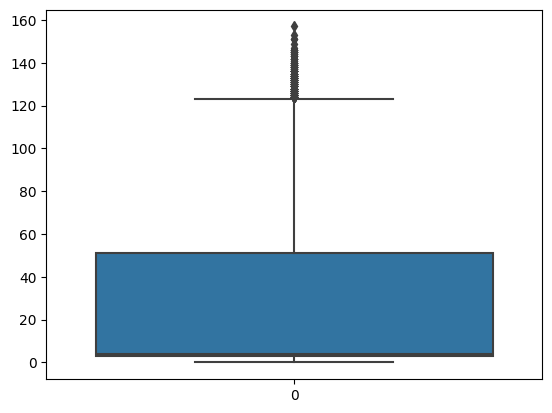

In [1427]:
sns.boxplot(df['Energy_Consumption'])

<Axes: >

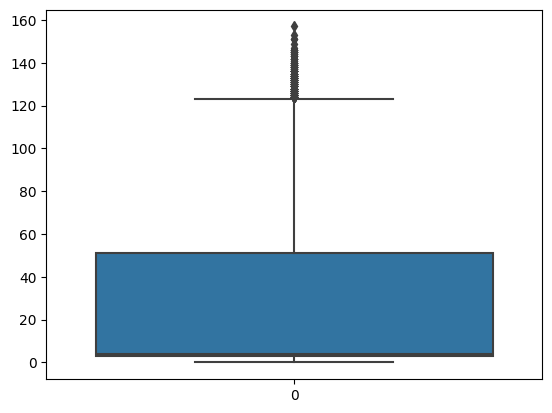

In [1428]:
sns.boxplot(df['Energy_Consumption'])

<Axes: >

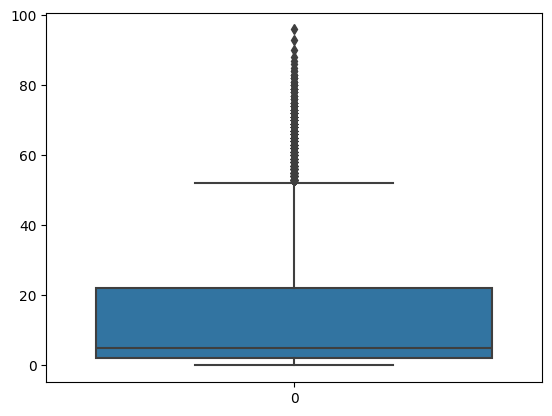

In [1429]:
sns.boxplot(df['LaRP'])

<Axes: >

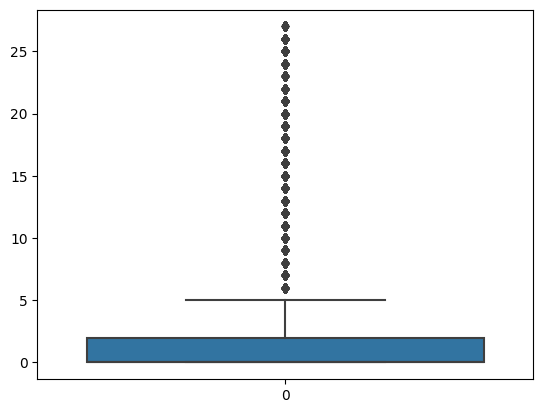

In [1430]:
sns.boxplot(df['LeRP'])

<Axes: >

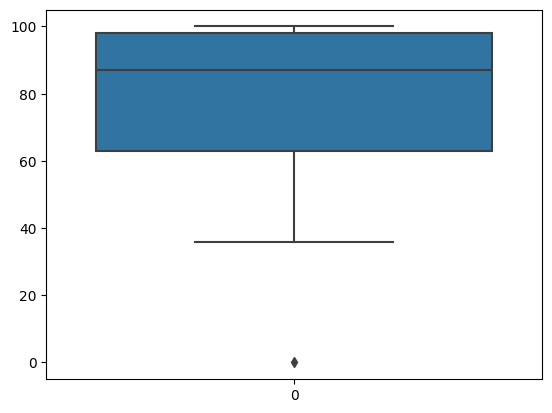

In [1349]:
sns.boxplot(df['LaPF']) 

<Axes: >

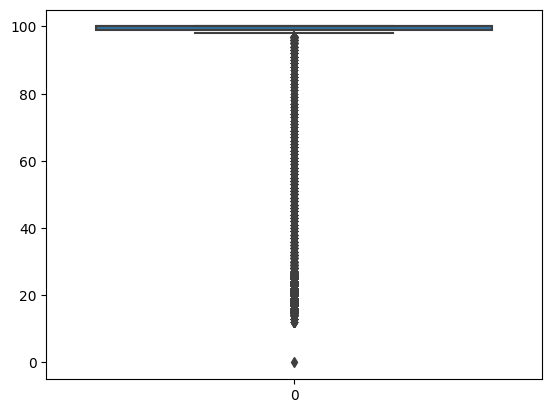

In [1353]:
sns.boxplot(df['LePF']) 

<Axes: >

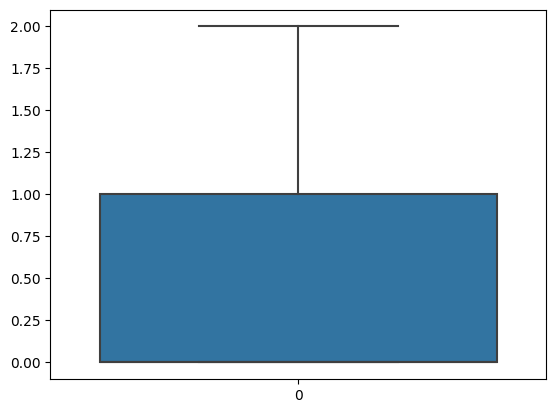

In [1354]:
sns.boxplot(df['Duty']) 

<Axes: >

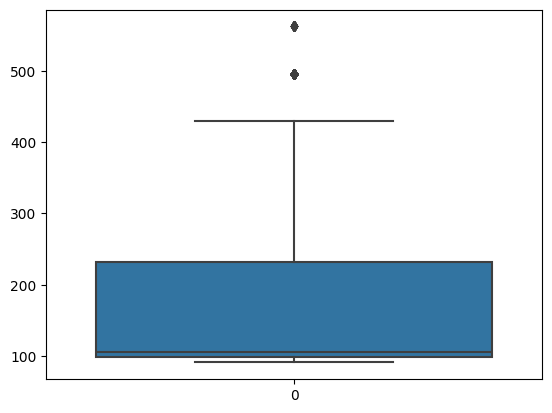

In [1355]:
sns.boxplot(df['Emissions_Air_Quality_Metric']) 

<Axes: >

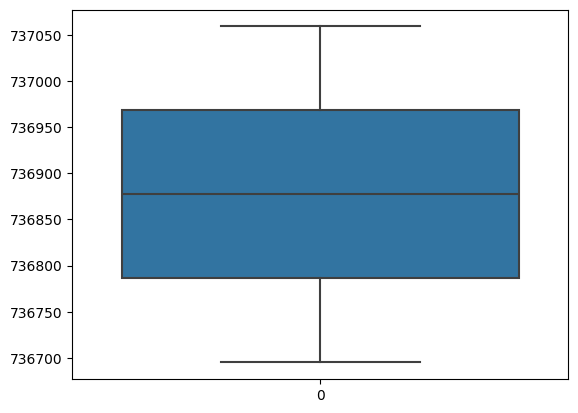

In [1356]:
sns.boxplot(df['Date']) 

<Axes: >

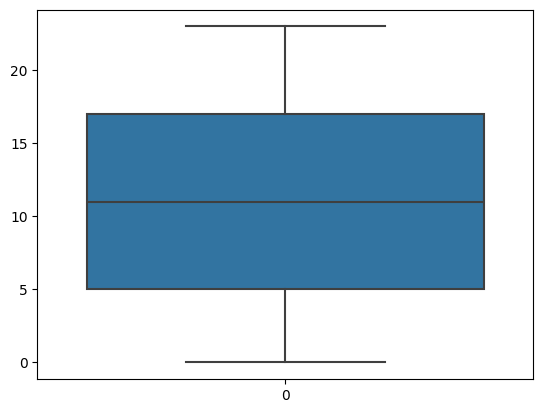

In [1357]:
sns.boxplot(df['hour']) 

<Axes: >

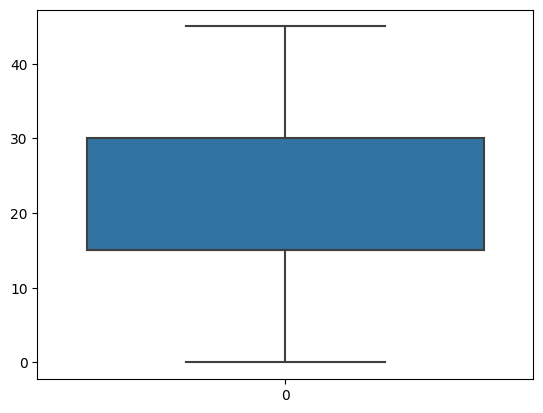

In [1358]:
sns.boxplot(df['minute']) 

In [1359]:
df

Energy_Consumption  LaRP  LeRP  LaPF  LePF  Duty  \
0                       3     2     0    73   100     0   
1                       3     4     0    66   100     0   
2                       3     3     0    70   100     0   
3                       3     3     0    68   100     0   
4                       3     4     0    64   100     0   
...                   ...   ...   ...   ...   ...   ...   
32845                   3     4     0    64   100     0   
32846                   3     3     0    70   100     0   
32847                   3     3     0    76    99     0   
32848                   3     3     0    77    99     0   
32849                   3     3     0    77    99     0   

       Emissions_Air_Quality_Metric    Date  hour  minute  second  
0                               105  736695     0      15       0  
1                               101  736695     0      30       0  
2                                94  736695     0      45       0  
3                                99  736695     1       0       0  
4                               109  736695     1      15       0  
...                             ...     ...   ...     ...     ...  
32845                            91  737059    22      45       0  
32846                            99  737059    23      15       0  
32847                           107  737059    23      30       0  
32848                           105  737059    23      45       0  
32849                            92  737059     0       0       0  

[32850 rows x 11 columns]

In [ ]:
# Outlier detected : Energy_Consumption,LaRP,LeRP,LaPF,LePF,Emissions_Air_Quality_Metric

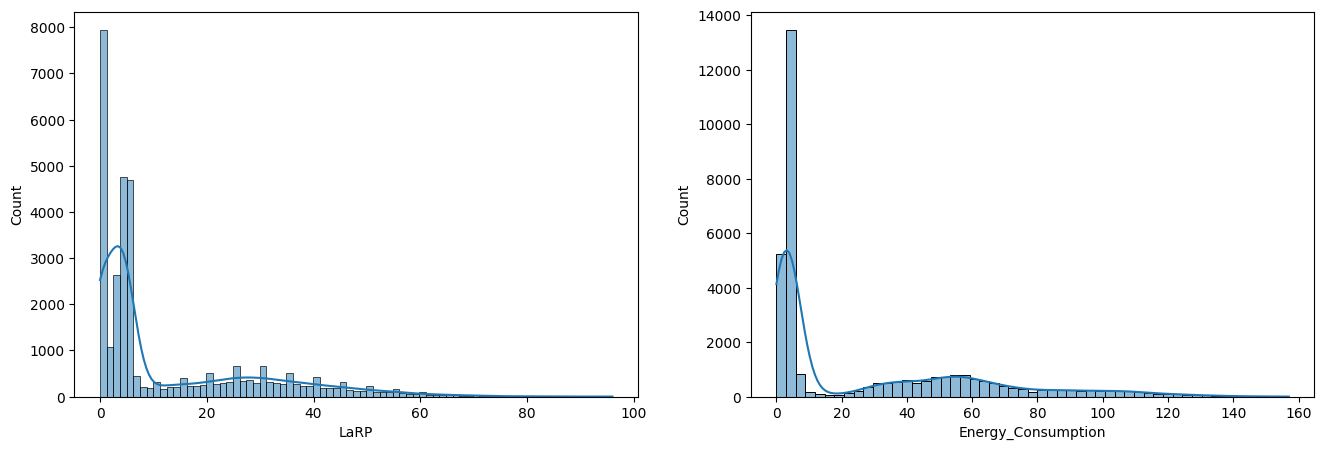

In [1360]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.histplot(df['LaRP'], kde=True)

plt.subplot(1,2,2)
sns.histplot(df['Energy_Consumption'], kde=True)

plt.show()

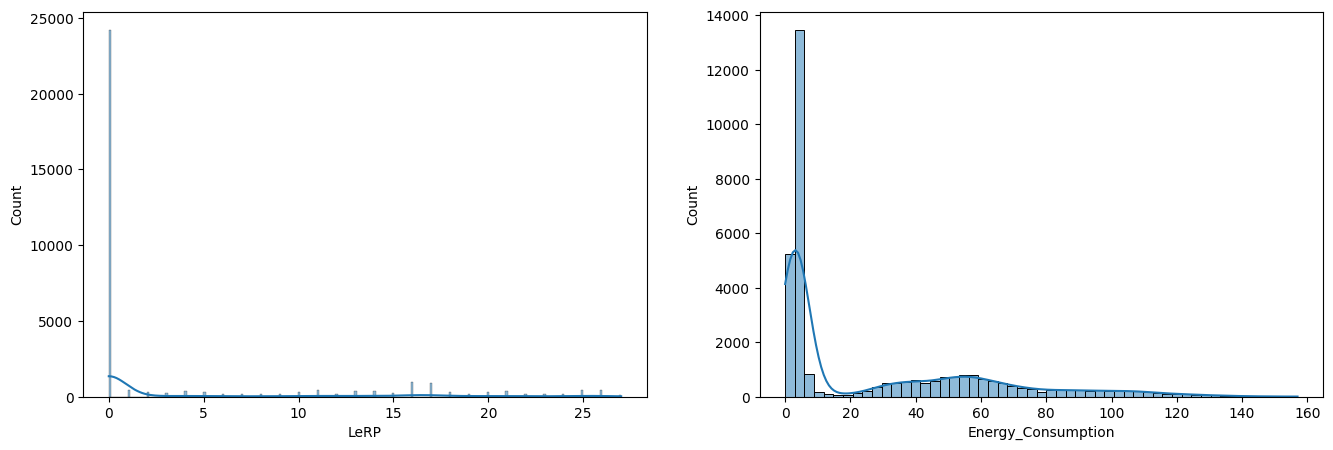

In [1361]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.histplot(df['LeRP'], kde=True)

plt.subplot(1,2,2)
sns.histplot(df['Energy_Consumption'], kde=True)

plt.show()

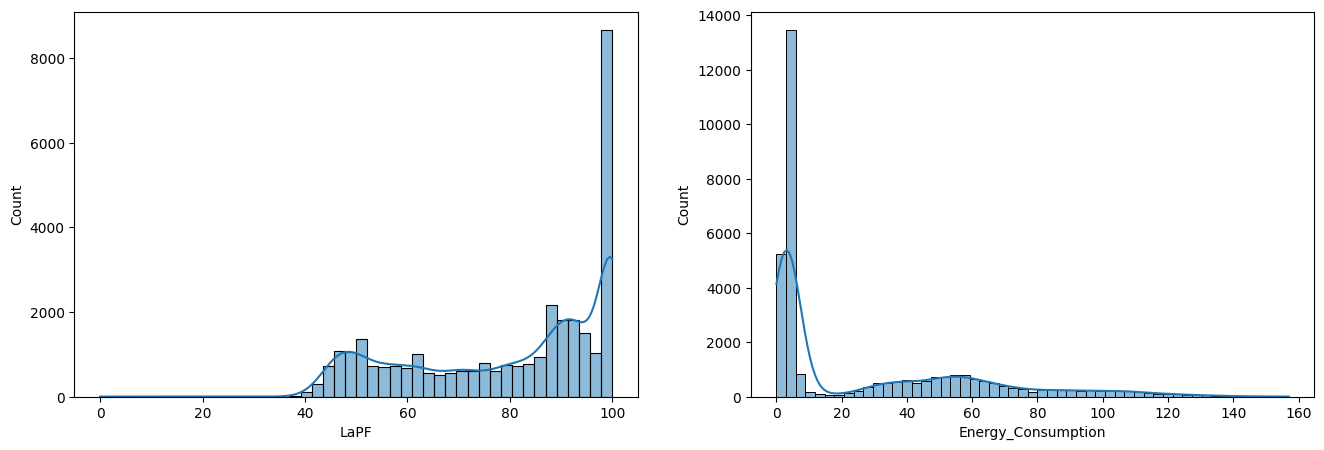

In [1362]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.histplot(df['LaPF'], kde=True)

plt.subplot(1,2,2)
sns.histplot(df['Energy_Consumption'], kde=True)

plt.show()

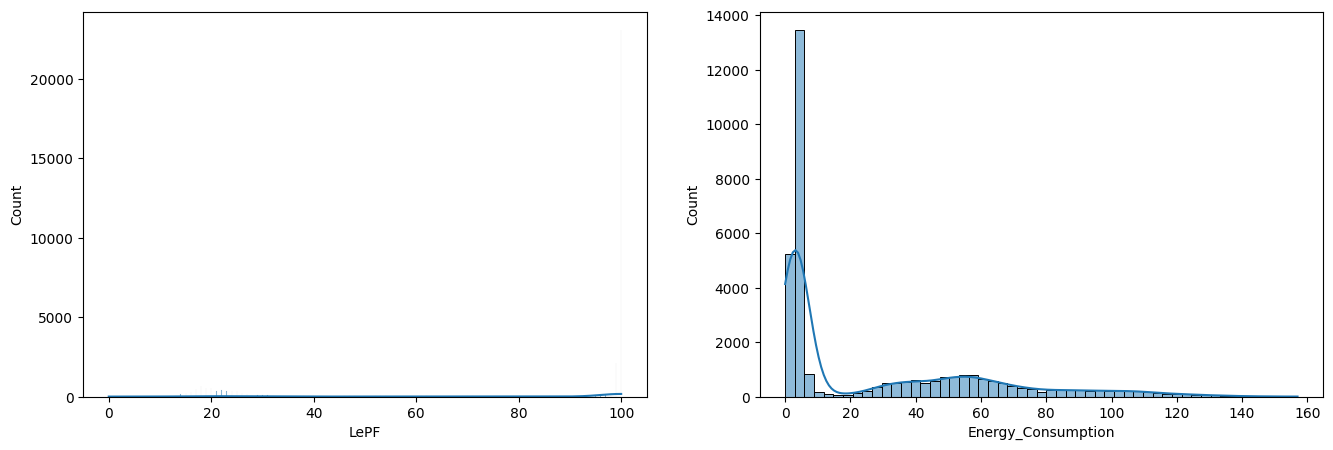

In [1431]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.histplot(df['LePF'], kde=True)

plt.subplot(1,2,2)
sns.histplot(df['Energy_Consumption'], kde=True)

plt.show()

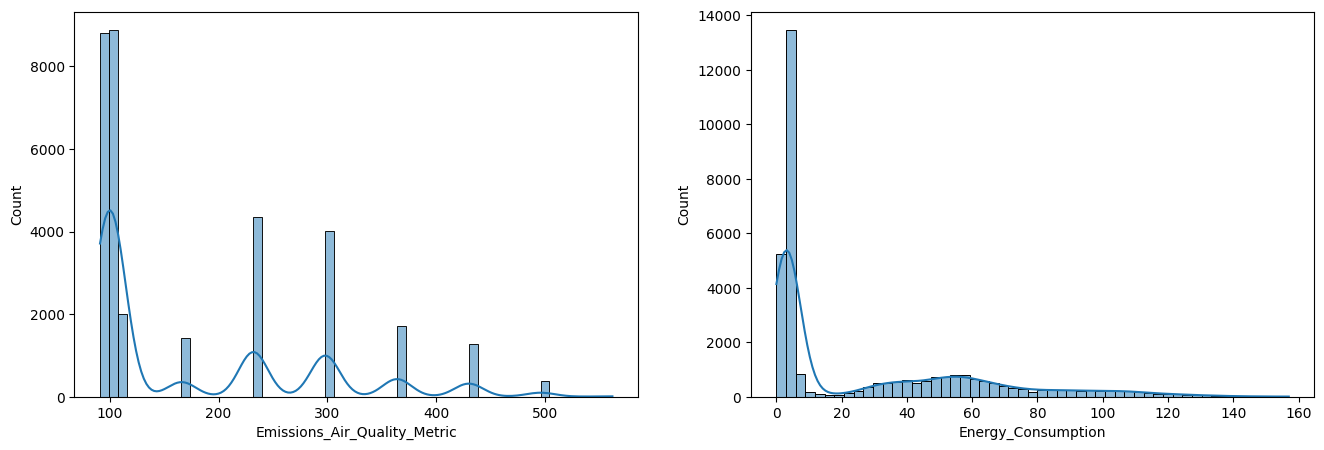

In [1432]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.histplot(df['Emissions_Air_Quality_Metric'], kde=True)

plt.subplot(1,2,2)
sns.histplot(df['Energy_Consumption'], kde=True)

plt.show()

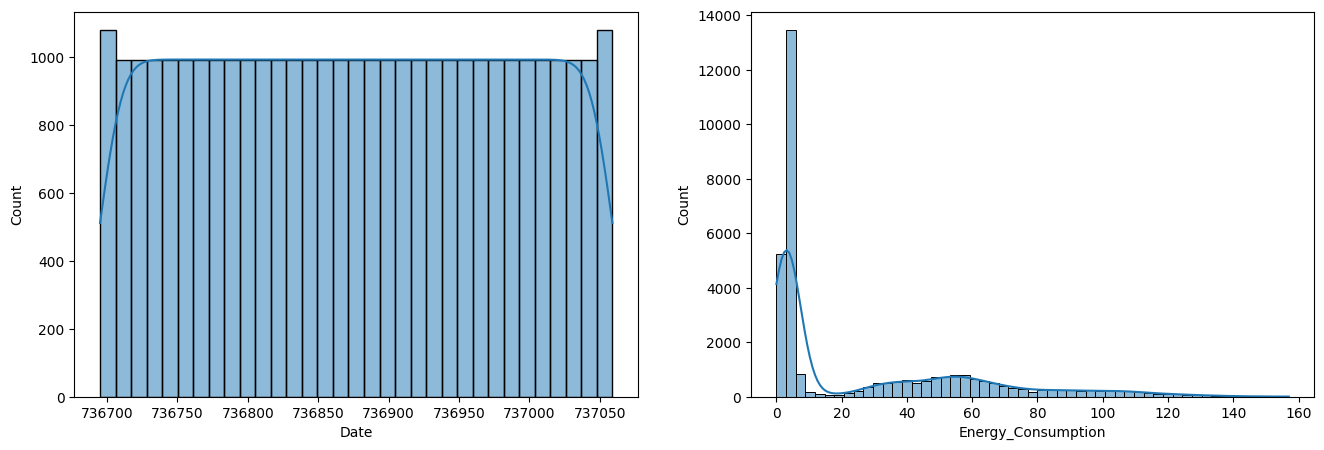

In [1364]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.histplot(df['Date'], kde=True)

plt.subplot(1,2,2)
sns.histplot(df['Energy_Consumption'], kde=True)

plt.show()

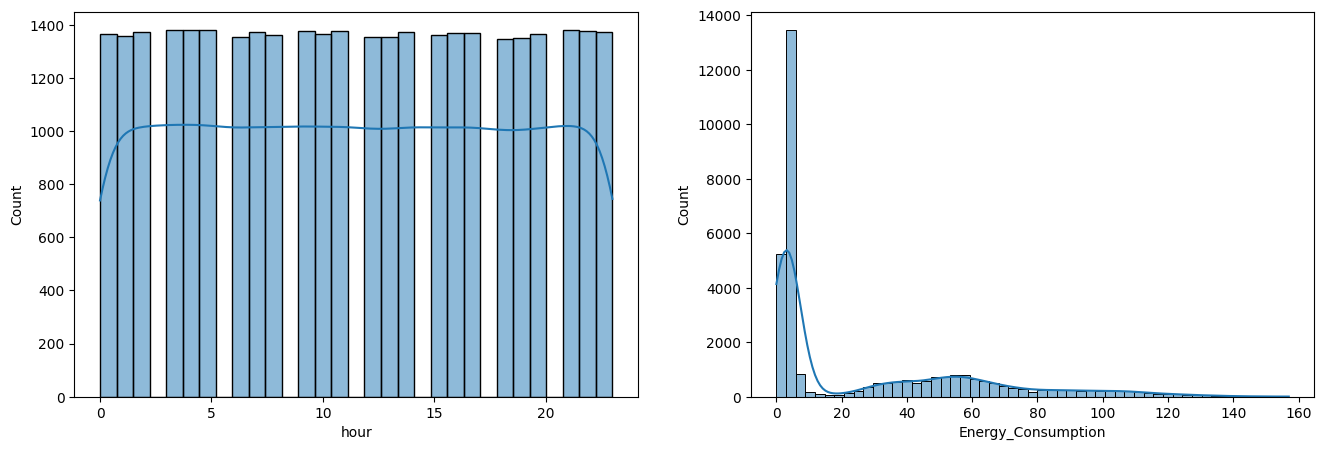

In [1365]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.histplot(df['hour'], kde=True)

plt.subplot(1,2,2)
sns.histplot(df['Energy_Consumption'], kde=True)

plt.show()

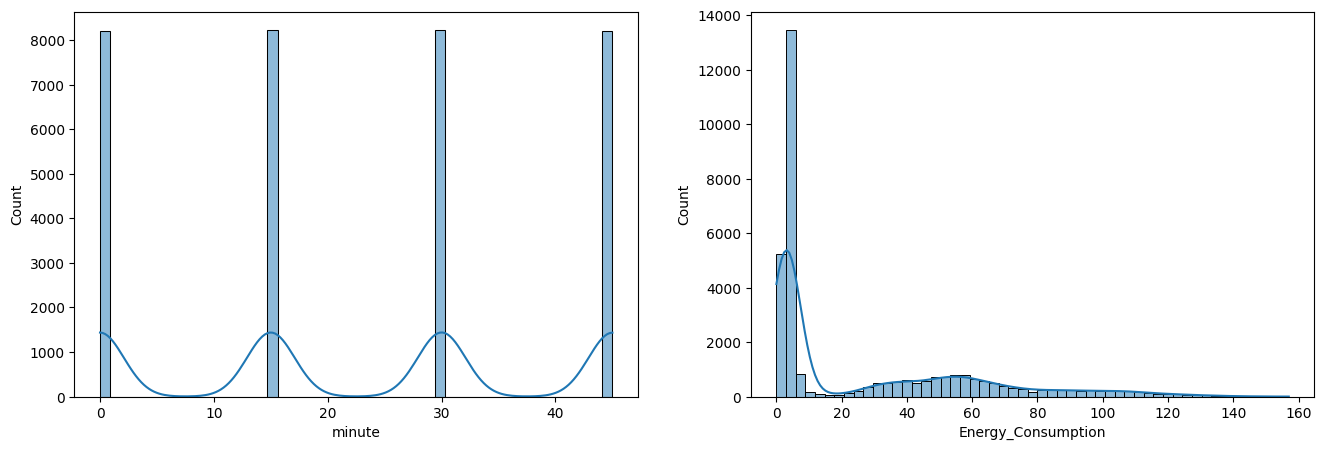

In [1366]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.histplot(df['minute'], kde=True)

plt.subplot(1,2,2)
sns.histplot(df['Energy_Consumption'], kde=True)

plt.show()

In [1367]:
df['Energy_Consumption'].describe()

count    32850.000000
mean        26.820457
std         33.381547
min          0.000000
25%          3.000000
50%          4.000000
75%         51.000000
max        157.000000
Name: Energy_Consumption, dtype: float64

<Axes: >

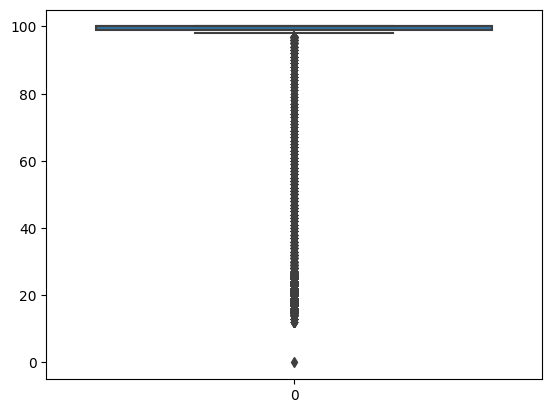

In [1433]:
sns.boxplot(df['LePF'])

In [1434]:
def remove_outliers_iqr(df, threshold=1.5):
    q1 = np.percentile(df, 25)
    q3 = np.percentile(df, 75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    outliers_removed = df[(df >= lower_bound) & (df <= upper_bound)]
    return outliers_removed

In [1435]:
outlier_removed = remove_outliers_iqr(df)

In [1436]:
outlier_removed

Energy_Consumption  LaRP  LeRP  LaPF  LePF  Duty  \
0                       3     2     0    73   100     0   
1                       3     4     0    66   100     0   
2                       3     3     0    70   100     0   
3                       3     3     0    68   100     0   
4                       3     4     0    64   100     0   
...                   ...   ...   ...   ...   ...   ...   
32845                   3     4     0    64   100     0   
32846                   3     3     0    70   100     0   
32847                   3     3     0    76    99     0   
32848                   3     3     0    77    99     0   
32849                   3     3     0    77    99     0   

       Emissions_Air_Quality_Metric  Date  hour  minute  second  
0                             105.0   NaN     0      15       0  
1                             101.0   NaN     0      30       0  
2                              94.0   NaN     0      45       0  
3                              99.0   NaN     1       0       0  
4                             109.0   NaN     1      15       0  
...                             ...   ...   ...     ...     ...  
32845                          91.0   NaN    22      45       0  
32846                          99.0   NaN    23      15       0  
32847                         107.0   NaN    23      30       0  
32848                         105.0   NaN    23      45       0  
32849                          92.0   NaN     0       0       0  

[32850 rows x 11 columns]

In [1437]:
df['Date'].value_counts()

Date
736695    90
736946    90
736944    90
736943    90
736942    90
          ..
736815    90
736814    90
736813    90
736812    90
737059    90
Name: count, Length: 365, dtype: int64

In [1438]:
df['Date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 32850 entries, 0 to 32849
Series name: Date
Non-Null Count  Dtype
--------------  -----
32850 non-null  int64
dtypes: int64(1)
memory usage: 256.8 KB


<Axes: >

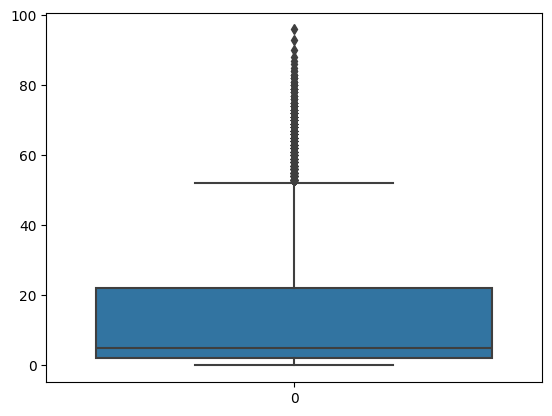

In [1439]:
sns.boxplot(data = df['LaRP'])

<Axes: >

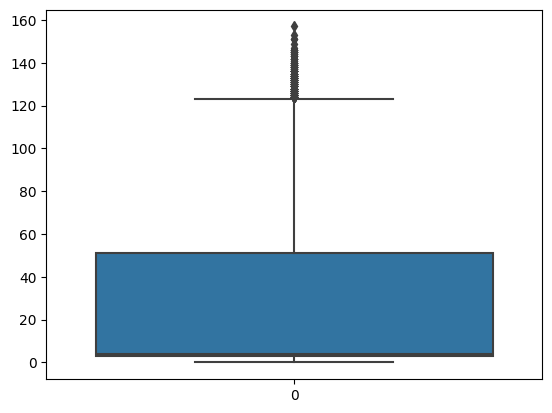

In [1440]:
sns.boxplot(data = df['Energy_Consumption'])

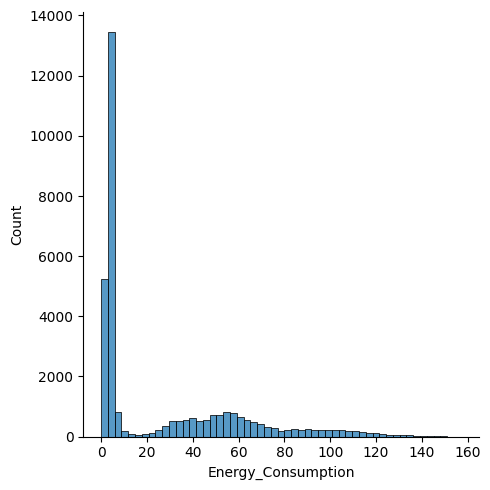

In [1441]:
sns.displot(df['Energy_Consumption'])

In [ ]:
# To see oulier clearly 

<Axes: >

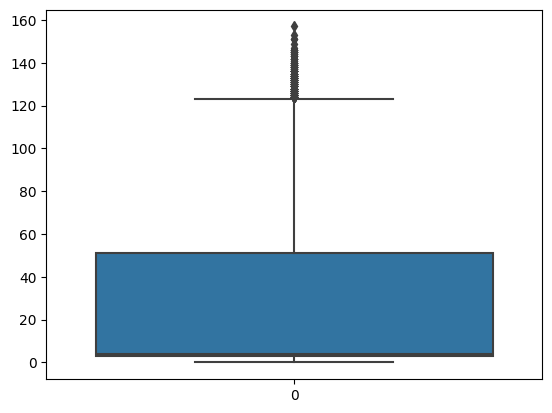

In [1442]:
sns.boxplot(df['Energy_Consumption'])

In [ ]:
# Z score method 

In [1195]:
upper_limit = df['Energy_Consumption'].mean()+3*df['Energy_Consumption'].std()
lower_limit = df['Energy_Consumption'].mean()-3*df['Energy_Consumption'].std()

In [1252]:
upper_limit

52.0

In [1253]:
lower_limit

-8.0

In [1254]:
# find the outliers
df.loc[(df['Energy_Consumption'] > upper_limit)| (df['Energy_Consumption'] < lower_limit)]

Energy_Consumption  LaRP  LeRP  LaPF  LePF  Duty  \
121                    56    12     0    97   100     0   
122                    56     8     0    98   100     1   
126                    54     7     0    99   100     2   
127                    53     8     0    98   100     2   
128                    80    32     0    92   100     2   
...                   ...   ...   ...   ...   ...   ...   
32530                  59    24     0    92   100     2   
32531                  62    27     0    91   100     2   
32532                  64    29     0    91   100     2   
32533                  59    23     0    92   100     2   
32539                  56    15     0    96   100     1   

       Emissions_Air_Quality_Metric    Date  hour  minute  second  
121                             107  736696     9       0       0  
122                             104  736696     9      15       0  
126                             100  736696    10      15       0  
127                             108  736696    10      30       0  
128                              93  736696    10      45       0  
...                             ...     ...   ...     ...     ...  
32530                           298  737056    10      45       0  
32531                           298  737056    11       0       0  
32532                           298  737056    11      30       0  
32533                           298  737056    11      45       0  
32539                           298  737056    13      30       0  

[7782 rows x 11 columns]

In [1255]:
df.loc[(df['Emissions_Air_Quality_Metric'] > upper_limit)| (df['Emissions_Air_Quality_Metric'] < lower_limit)]

Energy_Consumption  LaRP  LeRP  LaPF  LePF  Duty  \
0                       3     2     0    73   100     0   
1                       3     4     0    66   100     0   
2                       3     3     0    70   100     0   
3                       3     3     0    68   100     0   
4                       3     4     0    64   100     0   
...                   ...   ...   ...   ...   ...   ...   
32845                   3     4     0    64   100     0   
32846                   3     3     0    70   100     0   
32847                   3     3     0    76    99     0   
32848                   3     3     0    77    99     0   
32849                   3     3     0    77    99     0   

       Emissions_Air_Quality_Metric    Date  hour  minute  second  
0                               105  736695     0      15       0  
1                               101  736695     0      30       0  
2                                94  736695     0      45       0  
3                                99  736695     1       0       0  
4                               109  736695     1      15       0  
...                             ...     ...   ...     ...     ...  
32845                            91  737059    22      45       0  
32846                            99  737059    23      15       0  
32847                           107  737059    23      30       0  
32848                           105  737059    23      45       0  
32849                            92  737059     0       0       0  

[32850 rows x 11 columns]

In [ ]:
# trimming - del the oulier data

In [1372]:
clean_df = df.loc[(df['Energy_Consumption'] < upper_limit) & (df['Energy_Consumption'] > lower_limit)]
print('Before removing outliers',len(df))
print('After removing outliers',len(clean_df))
print('Outliers',len(df)-len(clean_df)) 

Before removing outliers 32850
After removing outliers 24834
Outliers 8016


In [1373]:
clean_df1 = df.loc[(df['Emissions_Air_Quality_Metric'] < upper_limit) & (df['Emissions_Air_Quality_Metric'] > lower_limit)]
print('Before removing outliers',len(df))
print('After removing outliers',len(clean_df1))
print('Outliers',len(df)-len(clean_df1))

Before removing outliers 32850
After removing outliers 0
Outliers 32850


<Axes: >

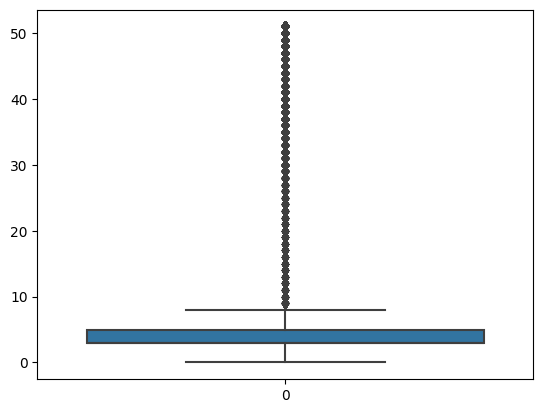

In [1374]:
sns.boxplot(clean_df['Energy_Consumption'])

<Axes: >

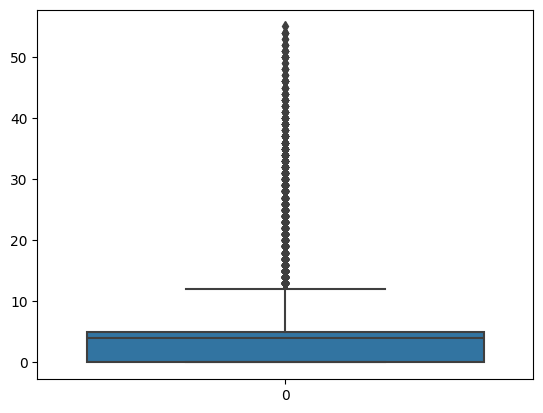

In [1259]:
sns.boxplot(clean_df['LaRP'])

In [1239]:
df

Energy_Consumption  LaRP  LeRP  LaPF  LePF  Duty  \
0                       3     2     0    73   100     0   
1                       3     4     0    66   100     0   
2                       3     3     0    70   100     0   
3                       3     3     0    68   100     0   
4                       3     4     0    64   100     0   
...                   ...   ...   ...   ...   ...   ...   
32845                   3     4     0    64   100     0   
32846                   3     3     0    70   100     0   
32847                   3     3     0    76    99     0   
32848                   3     3     0    77    99     0   
32849                   3     3     0    77    99     0   

       Emissions_Air_Quality_Metric    Date  hour  minute  second  
0                               105  736695     0      15       0  
1                               101  736695     0      30       0  
2                                94  736695     0      45       0  
3                                99  736695     1       0       0  
4                               109  736695     1      15       0  
...                             ...     ...   ...     ...     ...  
32845                            91  737059    22      45       0  
32846                            99  737059    23      15       0  
32847                           107  737059    23      30       0  
32848                           105  737059    23      45       0  
32849                            92  737059     0       0       0  

[32850 rows x 11 columns]

In [ ]:
# Capping - change the outlier values to upper or lower limit 

In [1232]:
clean_df1 = df.copy()
clean_df1.loc[(clean_df1['Energy_Consumption']>upper_limit),'Energy_Consumption'] = upper_limit
clean_df1.loc[(clean_df1['Energy_Consumption']<lower_limit),'Energy_Consumption'] = lower_limit

In [1240]:
len(clean_df)

32640

In [1241]:
df

Energy_Consumption  LaRP  LeRP  LaPF  LePF  Duty  \
0                       3     2     0    73   100     0   
1                       3     4     0    66   100     0   
2                       3     3     0    70   100     0   
3                       3     3     0    68   100     0   
4                       3     4     0    64   100     0   
...                   ...   ...   ...   ...   ...   ...   
32845                   3     4     0    64   100     0   
32846                   3     3     0    70   100     0   
32847                   3     3     0    76    99     0   
32848                   3     3     0    77    99     0   
32849                   3     3     0    77    99     0   

       Emissions_Air_Quality_Metric    Date  hour  minute  second  
0                               105  736695     0      15       0  
1                               101  736695     0      30       0  
2                                94  736695     0      45       0  
3                                99  736695     1       0       0  
4                               109  736695     1      15       0  
...                             ...     ...   ...     ...     ...  
32845                            91  737059    22      45       0  
32846                            99  737059    23      15       0  
32847                           107  737059    23      30       0  
32848                           105  737059    23      45       0  
32849                            92  737059     0       0       0  

[32850 rows x 11 columns]

In [ ]:
# IOR Method 

In [1242]:
q1 = df['Energy_Consumption'].quantile(0.25)
q3 = df['Energy_Consumption'].quantile(0.75)
IQR = q3-q1

In [1243]:
q1,q3,IQR

(3.0, 51.0, 48.0)

In [1244]:
upper_limit = q3 + (1.5*IQR)
lower_limit = q3 - (1.5*IQR)

In [1245]:
upper_limit

123.0

In [1246]:
lower_limit

-21.0

<Axes: >

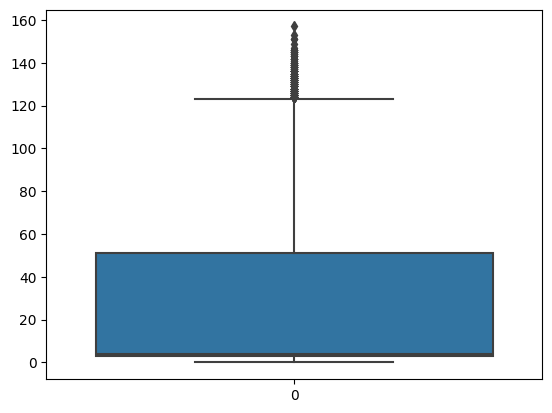

In [1247]:
sns.boxplot(df['Energy_Consumption'])

In [ ]:
# IQR FOR LaRP

In [1248]:
q1 = df['LaRP'].quantile(0.25)
q3 = df['LaRP'].quantile(0.75)
IQR = q3-q1
upper_limit = q3 + (1.5*IQR)
lower_limit = q3 - (1.5*IQR)

<Axes: >

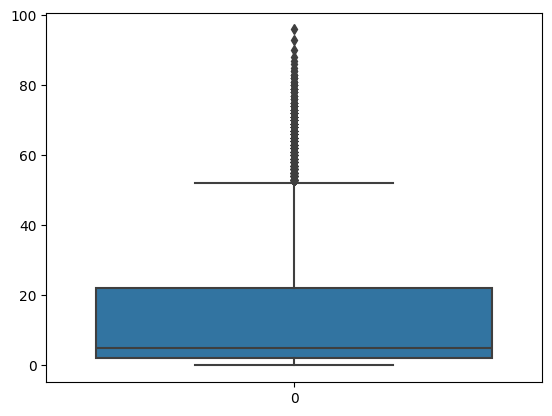

In [1249]:
sns.boxplot(df['LaRP'])

<Axes: ylabel='Energy_Consumption'>

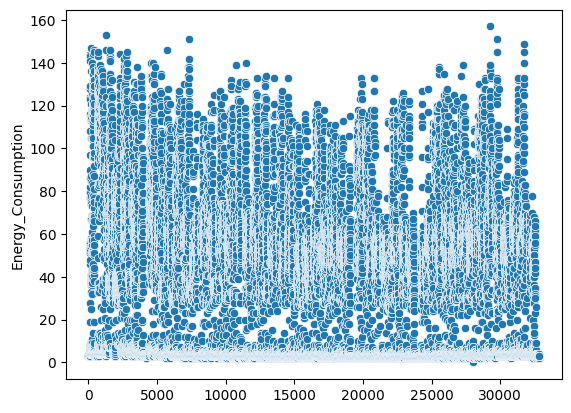

In [1250]:
sns.scatterplot(df['Energy_Consumption'])

<Axes: ylabel='LaRP'>

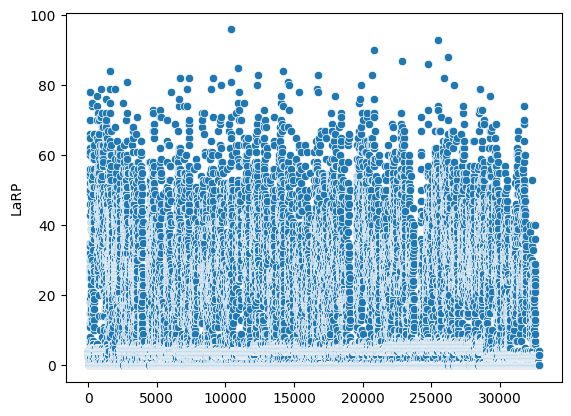

In [1251]:
sns.scatterplot(df['LaRP'])

# Testing the Model / testing for submission

In [1054]:
df1 = pd.read_csv('Test.csv')
df1.head()

Unnamed: 0            TimeStamp  LaRP   LeRP    LaPF    LePF Duty  \
0           0  2018-01-01 02:45:00  4.04   0.00   65.15  100.00  Low   
1           1  2018-01-01 09:45:00  0.00  19.22  100.00   20.00  Low   
2           2  2018-01-01 11:15:00  0.00   5.66  100.00   52.55  Low   
3           3  2018-01-01 18:15:00  0.00   8.96  100.00   40.77  Low   
4           4  2018-01-01 18:30:00  0.00   5.46  100.00   53.02  Low   

   Emissions_Air_Quality_Metric  
0                           109  
1                           104  
2                           100  
3                           106  
4                           104

In [1055]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    2190 non-null   int64  
 1   TimeStamp                     2190 non-null   object 
 2   LaRP                          2190 non-null   float64
 3   LeRP                          2190 non-null   float64
 4   LaPF                          2190 non-null   float64
 5   LePF                          2190 non-null   float64
 6   Duty                          2190 non-null   object 
 7   Emissions_Air_Quality_Metric  2190 non-null   int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 137.0+ KB


In [1056]:
df1 = df1.drop(columns=['Unnamed: 0'])
df1.head()

TimeStamp  LaRP   LeRP    LaPF    LePF Duty  \
0  2018-01-01 02:45:00  4.04   0.00   65.15  100.00  Low   
1  2018-01-01 09:45:00  0.00  19.22  100.00   20.00  Low   
2  2018-01-01 11:15:00  0.00   5.66  100.00   52.55  Low   
3  2018-01-01 18:15:00  0.00   8.96  100.00   40.77  Low   
4  2018-01-01 18:30:00  0.00   5.46  100.00   53.02  Low   

   Emissions_Air_Quality_Metric  
0                           109  
1                           104  
2                           100  
3                           106  
4                           104

In [1057]:
df1['Duty']=df1['Duty'].replace({'Low':0, 
                       'Average':1,
                       'Major':2})
df1.head()

TimeStamp  LaRP   LeRP    LaPF    LePF  Duty  \
0  2018-01-01 02:45:00  4.04   0.00   65.15  100.00     0   
1  2018-01-01 09:45:00  0.00  19.22  100.00   20.00     0   
2  2018-01-01 11:15:00  0.00   5.66  100.00   52.55     0   
3  2018-01-01 18:15:00  0.00   8.96  100.00   40.77     0   
4  2018-01-01 18:30:00  0.00   5.46  100.00   53.02     0   

   Emissions_Air_Quality_Metric  
0                           109  
1                           104  
2                           100  
3                           106  
4                           104

In [1058]:
df1['Duty'].value_counts

<bound method IndexOpsMixin.value_counts of 0       0
1       0
2       0
3       0
4       0
       ..
2185    0
2186    0
2187    0
2188    0
2189    0
Name: Duty, Length: 2190, dtype: int64>

In [997]:
#df1['TimeStamp'] = pd.to_datetime(df1['TimeStamp'], format='%Y-%m-%d %H:%M:%S')
#df1['Ordinal'] = df1['TimeStamp'].map(dt.datetime.toordinal)

In [1059]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   TimeStamp                     2190 non-null   object 
 1   LaRP                          2190 non-null   float64
 2   LeRP                          2190 non-null   float64
 3   LaPF                          2190 non-null   float64
 4   LePF                          2190 non-null   float64
 5   Duty                          2190 non-null   int64  
 6   Emissions_Air_Quality_Metric  2190 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 119.9+ KB


In [1060]:
df1['LaRP'] = df1['LaRP'].astype(int)

In [1061]:
df1['LeRP'] = df1['LeRP'].astype(int)

In [1062]:
df1['LaPF'] = df1['LaPF'].astype(int)

In [1063]:
df1['LePF'] = df1['LePF'].astype(int)

In [1064]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   TimeStamp                     2190 non-null   object
 1   LaRP                          2190 non-null   int64 
 2   LeRP                          2190 non-null   int64 
 3   LaPF                          2190 non-null   int64 
 4   LePF                          2190 non-null   int64 
 5   Duty                          2190 non-null   int64 
 6   Emissions_Air_Quality_Metric  2190 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 119.9+ KB


In [1004]:
#df1['Date'] = pd.to_datetime(df1['Date'], format='%y-%m-%d  %H-%M-%S')
#df1['TimeStamp'] = df1['TimeStamp'].map(dt.datetime.toordinal)

In [1069]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Date                          2190 non-null   object
 1   LaRP                          2190 non-null   int64 
 2   LeRP                          2190 non-null   int64 
 3   LaPF                          2190 non-null   int64 
 4   LePF                          2190 non-null   int64 
 5   Duty                          2190 non-null   int64 
 6   Emissions_Air_Quality_Metric  2190 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 119.9+ KB


In [1067]:
#df1 = df1.drop(columns = ['minute'])


In [1068]:
df1.rename({'TimeStamp': 'Date'}, axis=1, inplace=True)

print(df1)

                     Date  LaRP  LeRP  LaPF  LePF  Duty  \
0     2018-01-01 02:45:00     4     0    65   100     0   
1     2018-01-01 09:45:00     0    19   100    20     0   
2     2018-01-01 11:15:00     0     5   100    52     0   
3     2018-01-01 18:15:00     0     8   100    40     0   
4     2018-01-01 18:30:00     0     5   100    53     0   
...                   ...   ...   ...   ...   ...   ...   
2185  2018-12-31 12:45:00     0    13   100    24     0   
2186  2018-12-31 13:30:00     0    13   100    23     0   
2187  2018-12-31 18:15:00     0     5   100    49     0   
2188  2018-12-31 20:00:00     0    20   100    20     0   
2189  2018-12-31 23:00:00     4     0    62   100     0   

      Emissions_Air_Quality_Metric  
0                              109  
1                              104  
2                              100  
3                              106  
4                              104  
...                            ...  
2185                            

In [1010]:
# X_train = X_train.reset_index(drop=True)

In [1011]:
#df1['Date'] = pd.to_datetime(df1['Date'], unit='s')

In [1012]:
#df1['Date'] = pd.to_datetime(df1['Date'])

In [1074]:
df1['hour'] = df1['Date'].dt.hour
df1['minute'] = df1['Date'].dt.minute
df1['second'] = df1['Date'].dt.second
df1

Date  LaRP  LeRP  LaPF  LePF  Duty  \
0    2018-01-01 02:45:00     4     0    65   100     0   
1    2018-01-01 09:45:00     0    19   100    20     0   
2    2018-01-01 11:15:00     0     5   100    52     0   
3    2018-01-01 18:15:00     0     8   100    40     0   
4    2018-01-01 18:30:00     0     5   100    53     0   
...                  ...   ...   ...   ...   ...   ...   
2185 2018-12-31 12:45:00     0    13   100    24     0   
2186 2018-12-31 13:30:00     0    13   100    23     0   
2187 2018-12-31 18:15:00     0     5   100    49     0   
2188 2018-12-31 20:00:00     0    20   100    20     0   
2189 2018-12-31 23:00:00     4     0    62   100     0   

      Emissions_Air_Quality_Metric  hour  minute  second  
0                              109     2      45       0  
1                              104     9      45       0  
2                              100    11      15       0  
3                              106    18      15       0  
4                              104    18      30       0  
...                            ...   ...     ...     ...  
2185                            96    12      45       0  
2186                            99    13      30       0  
2187                           101    18      15       0  
2188                           105    20       0       0  
2189                            96    23       0       0  

[2190 rows x 10 columns]

In [1075]:
df1['Date'] = df1['Date'].dt.strftime("%d-%m-%y")
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Date                          2190 non-null   object
 1   LaRP                          2190 non-null   int64 
 2   LeRP                          2190 non-null   int64 
 3   LaPF                          2190 non-null   int64 
 4   LePF                          2190 non-null   int64 
 5   Duty                          2190 non-null   int64 
 6   Emissions_Air_Quality_Metric  2190 non-null   int64 
 7   hour                          2190 non-null   int32 
 8   minute                        2190 non-null   int32 
 9   second                        2190 non-null   int32 
dtypes: int32(3), int64(6), object(1)
memory usage: 145.6+ KB


In [1081]:
df1['hour'].value_counts()

hour
18    113
19    109
13    105
6     105
12    103
1     101
8      97
15     97
0      94
10     94
20     92
16     91
17     89
23     87
2      85
14     84
7      84
22     83
11     83
9      81
3      79
4      78
21     78
5      78
Name: count, dtype: int64

In [1079]:
df1['minute'].value_counts()

minute
45    562
0     551
15    543
30    534
Name: count, dtype: int64

In [1080]:
df1['second'].value_counts()

second
0    2190
Name: count, dtype: int64

In [1082]:
df['second'].value_counts()

second
0    32850
Name: count, dtype: int64

In [1083]:
df

Energy_Consumption  LaRP  LeRP  LaPF  LePF Duty  \
0                       3     2     0    73   100  Low   
1                       3     4     0    66   100  Low   
2                       3     3     0    70   100  Low   
3                       3     3     0    68   100  Low   
4                       3     4     0    64   100  Low   
...                   ...   ...   ...   ...   ...  ...   
32845                   3     4     0    64   100  Low   
32846                   3     3     0    70   100  Low   
32847                   3     3     0    76    99  Low   
32848                   3     3     0    77    99  Low   
32849                   3     3     0    77    99  Low   

       Emissions_Air_Quality_Metric    Date  hour  minute  second  
0                               105  736695     0      15       0  
1                               101  736695     0      30       0  
2                                94  736695     0      45       0  
3                                99  736695     1       0       0  
4                               109  736695     1      15       0  
...                             ...     ...   ...     ...     ...  
32845                            91  737059    22      45       0  
32846                            99  737059    23      15       0  
32847                           107  737059    23      30       0  
32848                           105  737059    23      45       0  
32849                            92  737059     0       0       0  

[32850 rows x 11 columns]

In [ ]:
# df = df.drop(columns=['second'])
# df1 = df1.drop(columns=['second'])

In [1072]:
from datetime import datetime

In [1073]:
df1['Date'] = pd.to_datetime(df1.Date)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date                          2190 non-null   datetime64[ns]
 1   LaRP                          2190 non-null   int64         
 2   LeRP                          2190 non-null   int64         
 3   LaPF                          2190 non-null   int64         
 4   LePF                          2190 non-null   int64         
 5   Duty                          2190 non-null   int64         
 6   Emissions_Air_Quality_Metric  2190 non-null   int64         
dtypes: datetime64[ns](1), int64(6)
memory usage: 119.9 KB


In [1017]:
df1['Date'] = df1['Date'].map(dt.datetime.toordinal)

In [1018]:
X_train

LaRP  LeRP  LaPF  LePF  Emissions_Air_Quality_Metric    Date
32770     2     0    81    99                           109  737059
25842     5     0    47   100                            94  736982
28639     4     0    59   100                            97  737013
1789      0     5   100    98                           232  736714
30597     3     0    73   100                            96  737034
...     ...   ...   ...   ...                           ...     ...
32469    12     0    97   100                           232  737055
16317     3     0    62   100                            95  736876
12895     5     0    55   100                           105  736838
6012     20     0    94   100                           298  736761
6558      0    24   100    18                            98  736767

[22995 rows x 6 columns]

In [1019]:
df1

Date  LaRP  LeRP  LaPF  LePF  Duty  Emissions_Air_Quality_Metric
0     736695     4     0    65   100     0                           109
1     736695     0    19   100    20     0                           104
2     736695     0     5   100    52     0                           100
3     736695     0     8   100    40     0                           106
4     736695     0     5   100    53     0                           104
...      ...   ...   ...   ...   ...   ...                           ...
2185  737059     0    13   100    24     0                            96
2186  737059     0    13   100    23     0                            99
2187  737059     0     5   100    49     0                           101
2188  737059     0    20   100    20     0                           105
2189  737059     4     0    62   100     0                            96

[2190 rows x 7 columns]

In [1020]:
columns = [col for col in df1.columns if col != 'Date'] + ['Date']
df1 = df1[columns]

df1

LaRP  LeRP  LaPF  LePF  Duty  Emissions_Air_Quality_Metric    Date
0        4     0    65   100     0                           109  736695
1        0    19   100    20     0                           104  736695
2        0     5   100    52     0                           100  736695
3        0     8   100    40     0                           106  736695
4        0     5   100    53     0                           104  736695
...    ...   ...   ...   ...   ...                           ...     ...
2185     0    13   100    24     0                            96  737059
2186     0    13   100    23     0                            99  737059
2187     0     5   100    49     0                           101  737059
2188     0    20   100    20     0                           105  737059
2189     4     0    62   100     0                            96  737059

[2190 rows x 7 columns]

In [1026]:
df1=df1.drop(columns=['Duty'])

In [1027]:
df1

LaRP  LeRP  LaPF  LePF  Emissions_Air_Quality_Metric    Date
0        4     0    65   100                           109  736695
1        0    19   100    20                           104  736695
2        0     5   100    52                           100  736695
3        0     8   100    40                           106  736695
4        0     5   100    53                           104  736695
...    ...   ...   ...   ...                           ...     ...
2185     0    13   100    24                            96  737059
2186     0    13   100    23                            99  737059
2187     0     5   100    49                           101  737059
2188     0    20   100    20                           105  737059
2189     4     0    62   100                            96  737059

[2190 rows x 6 columns]

In [1028]:
X_train

LaRP  LeRP  LaPF  LePF  Emissions_Air_Quality_Metric    Date
32770     2     0    81    99                           109  737059
25842     5     0    47   100                            94  736982
28639     4     0    59   100                            97  737013
1789      0     5   100    98                           232  736714
30597     3     0    73   100                            96  737034
...     ...   ...   ...   ...                           ...     ...
32469    12     0    97   100                           232  737055
16317     3     0    62   100                            95  736876
12895     5     0    55   100                           105  736838
6012     20     0    94   100                           298  736761
6558      0    24   100    18                            98  736767

[22995 rows x 6 columns]

In [1029]:
predictions1 = my_first_model.predict(df1)
predictions1

array([6.52819459, 5.10096218, 4.91550046, ..., 3.57251582, 4.12779323,
       1.50361472])

In [1030]:
predictions1_new = pd.DataFrame(predictions1, columns=['Prediction'])

In [1031]:
predictions1_new.reset_index(inplace= True)

In [1024]:
predictions1_new.to_csv("vasundhra_submission_1.csv")

In [1025]:
file_path = 'predictions1_new.xlsx'
new_df1_with_predictions.to_excel(file_path, index=False)

print(f"DataFrame saved to {file_path}")

DataFrame saved to predictions1_new.xlsx


In [ ]:
# Model 2 

In [1032]:
predictions1_new

index  Prediction
0         0    6.528195
1         1    5.100962
2         2    4.915500
3         3    5.816443
4         4    5.989736
...     ...         ...
2185   2185    1.326104
2186   2186    1.990236
2187   2187    3.572516
2188   2188    4.127793
2189   2189    1.503615

[2190 rows x 2 columns]

In [ ]:
# Feature Importance Ananlysis and corr

In [338]:
df.corr()[['Energy_Consumption']].sort_values(by=['Energy_Consumption'],ascending=True)

Energy_Consumption
LeRP                                   -0.322834
Date                                   -0.112870
minute                                  0.017021
hour                                    0.234888
LePF                                    0.352838
LaPF                                    0.382489
Duty                                    0.616014
LaRP                                    0.895486
Emissions_Air_Quality_Metric            0.987275
Energy_Consumption                      1.000000
second                                       NaN

Strong Positive Correlations: LaRP, Emissions_Air_Quality_Metric, Duty.

Moderate Positive Correlations: LaPF, LePF.

Weak Positive Correlation: Hour.

Weak Negative Correlation: Date.

Moderate Negative Correlation: LeRP.

Negligible Correlation: Minute.

Undefined Correlation: Second.

In [ ]:
# drop columns - second,minute cos the column will be inaccurate, will affect the accuracy of the model.

In [ ]:
# K fold validation - 5splits in the training data set
# cross valid,stratified valid

In [ ]:
# ols 

In [ ]:
# Can we utilize the linear regression? 

are the assumptions holding true 

1. Normality of the residuals -- Histogram,KDE Plot
2. Homoskedasity
3. linear dependence
4. Independence of variable - lesser correlation - why?

In [ ]:
## EDA - Data Exploration

<Axes: xlabel='Emissions_Air_Quality_Metric', ylabel='Energy_Consumption'>

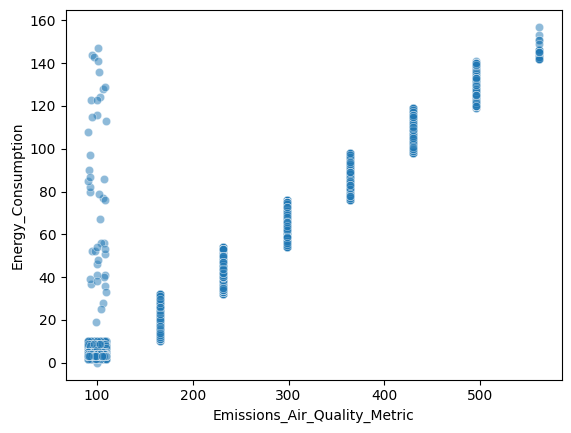

In [357]:
sns.scatterplot(x='Emissions_Air_Quality_Metric',y='Energy_Consumption',data=df,alpha=0.5)

<Axes: xlabel='LeRP', ylabel='Energy_Consumption'>

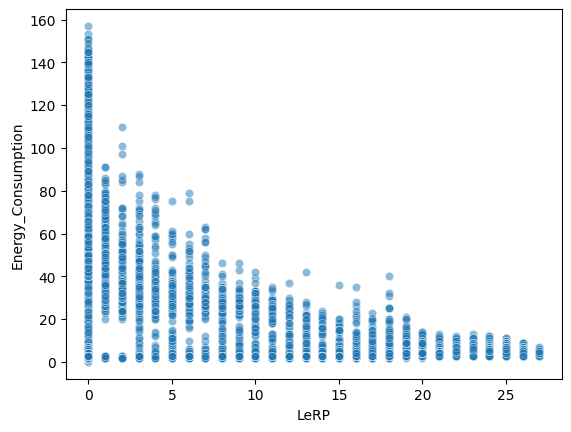

In [358]:
sns.scatterplot(x='LeRP',y='Energy_Consumption',data=df,alpha=0.5)

<Axes: xlabel='LaRP', ylabel='Energy_Consumption'>

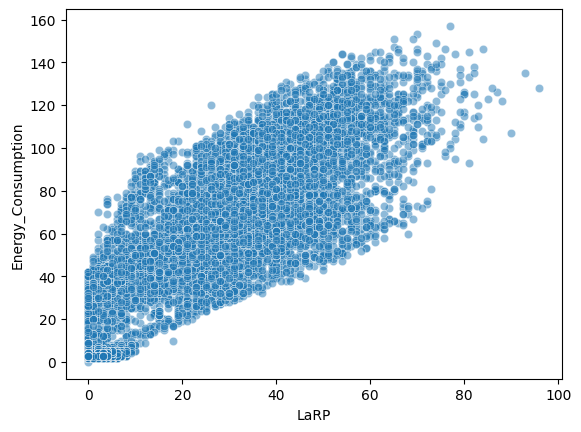

In [359]:
sns.scatterplot(x='LaRP',y='Energy_Consumption',data=df,alpha=0.5)

<Axes: xlabel='LaPF', ylabel='Energy_Consumption'>

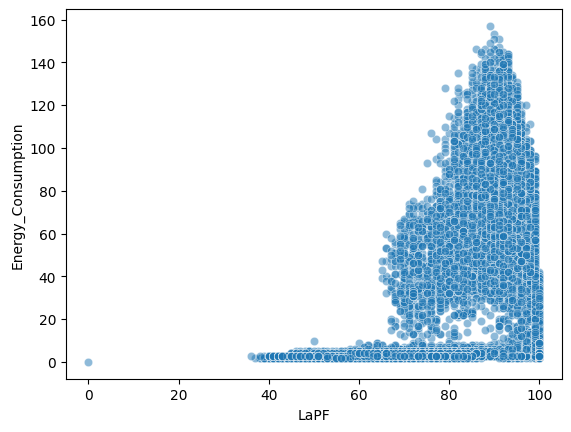

In [360]:
sns.scatterplot(x='LaPF',y='Energy_Consumption',data=df,alpha=0.5)

<Axes: xlabel='LePF', ylabel='Energy_Consumption'>

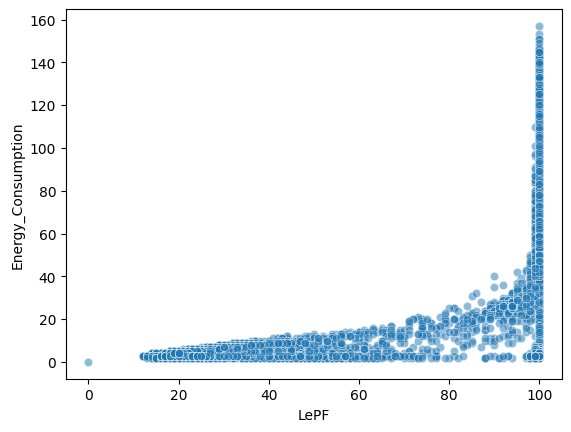

In [361]:
sns.scatterplot(x='LePF',y='Energy_Consumption',data=df,alpha=0.5)

<Axes: xlabel='Duty', ylabel='Energy_Consumption'>

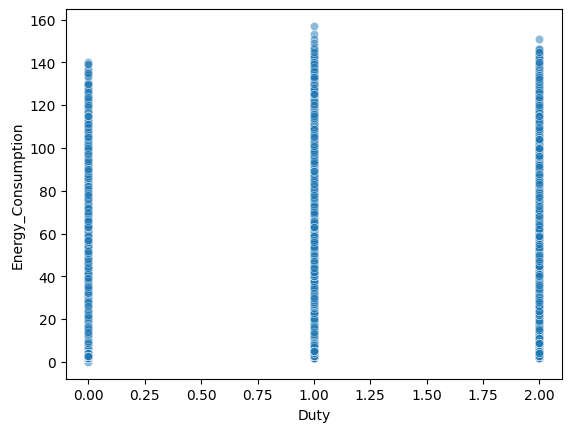

In [362]:
sns.scatterplot(x='Duty',y='Energy_Consumption',data=df,alpha=0.5)

<Axes: xlabel='Date', ylabel='Energy_Consumption'>

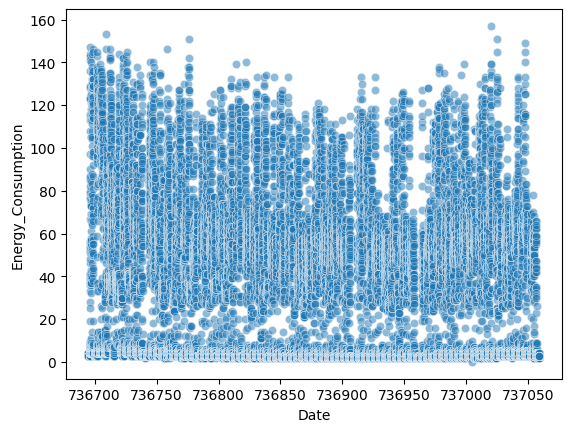

In [363]:
sns.scatterplot(x='Date',y='Energy_Consumption',data=df,alpha=0.5)

<Axes: xlabel='hour', ylabel='Energy_Consumption'>

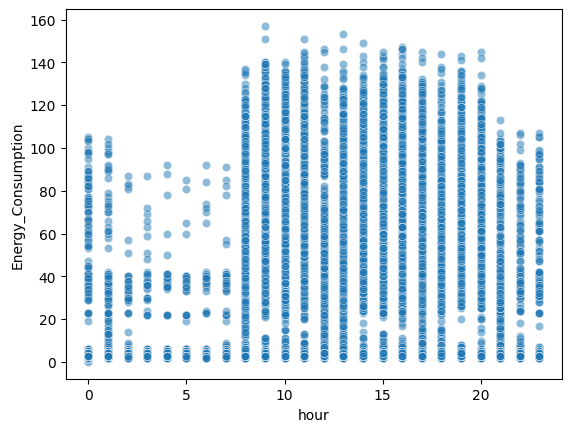

In [364]:
sns.scatterplot(x='hour',y='Energy_Consumption',data=df,alpha=0.5)

<Axes: xlabel='minute', ylabel='Energy_Consumption'>

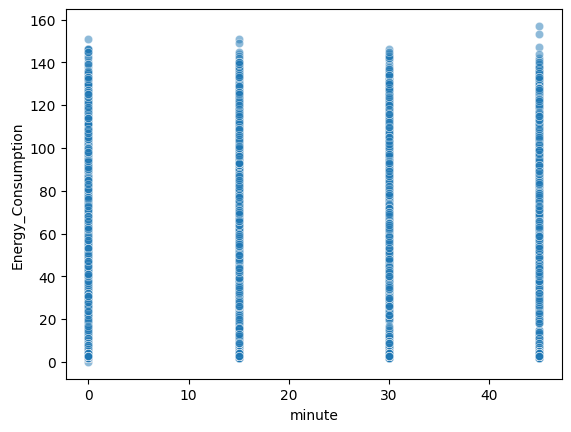

In [365]:
sns.scatterplot(x='minute',y='Energy_Consumption',data=df,alpha=0.5)

<Axes: xlabel='second', ylabel='Energy_Consumption'>

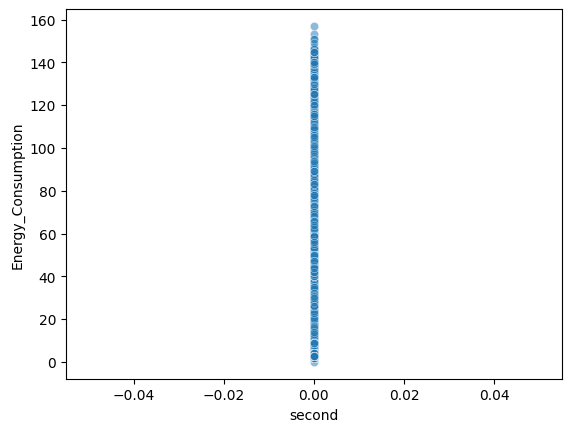

In [366]:
sns.scatterplot(x='second',y='Energy_Consumption',data=df,alpha=0.5)

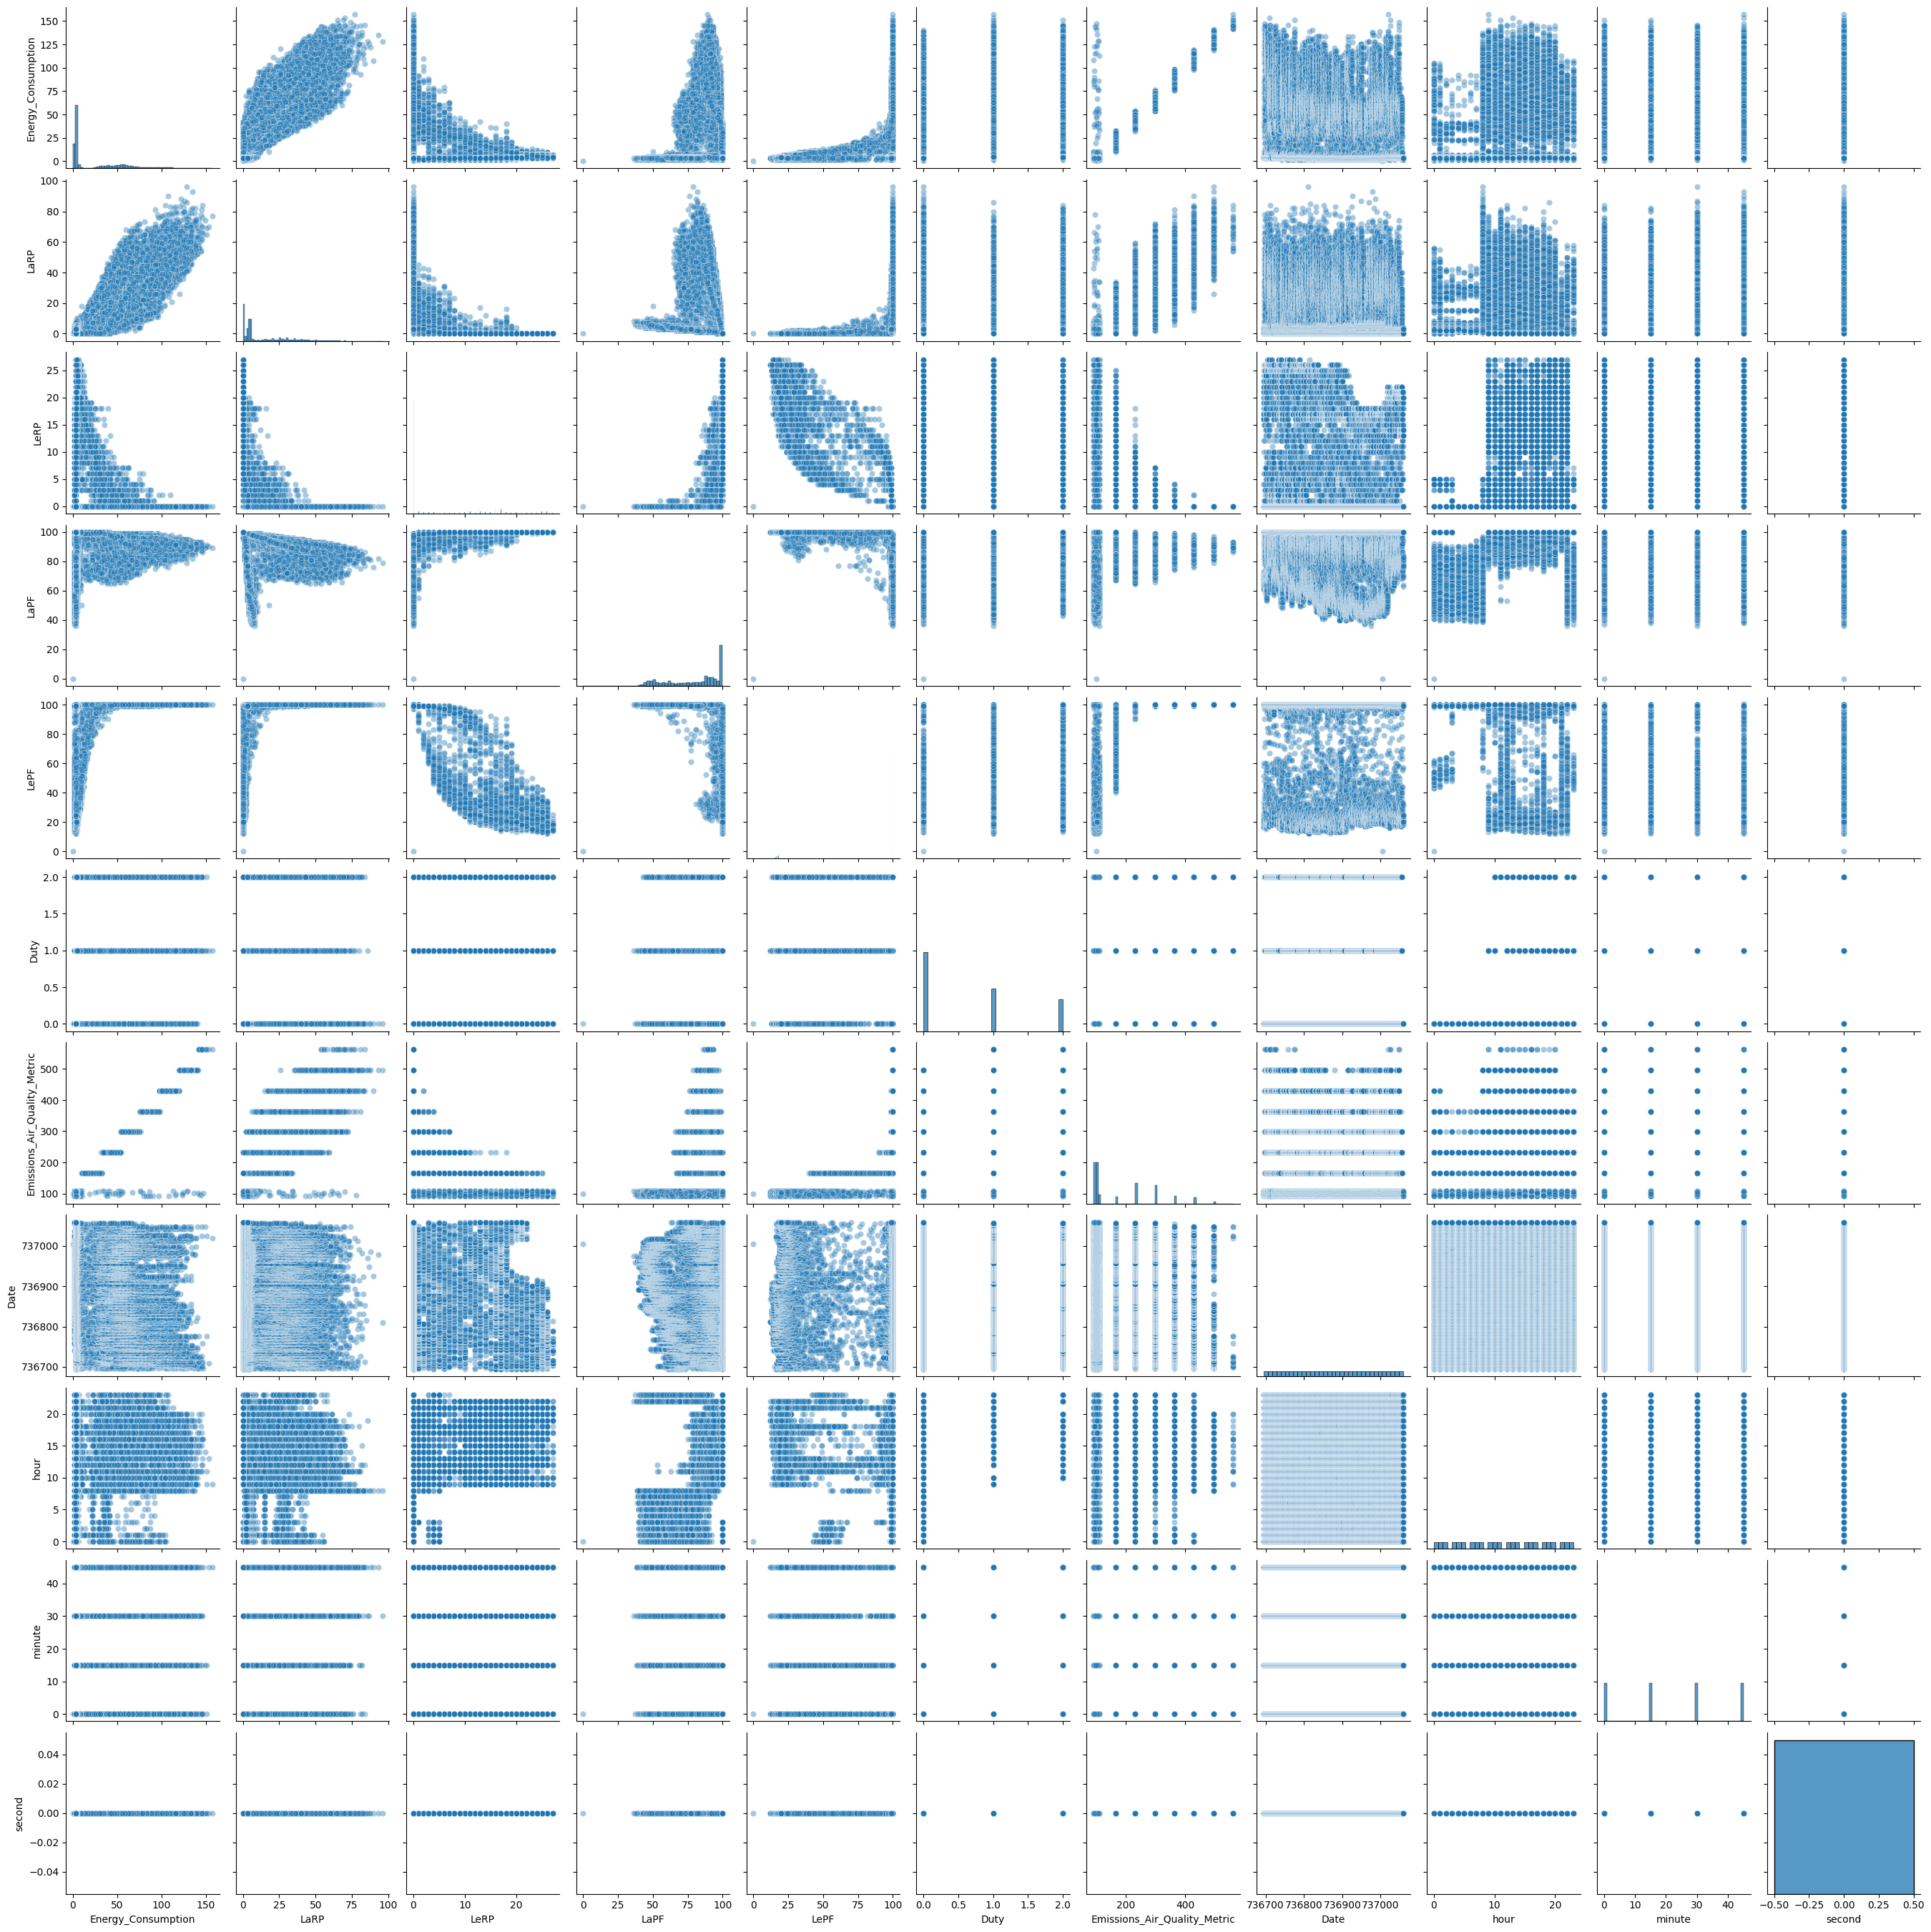

In [371]:
sns.pairplot(df,kind='scatter', plot_kws={'alpha':0.4})

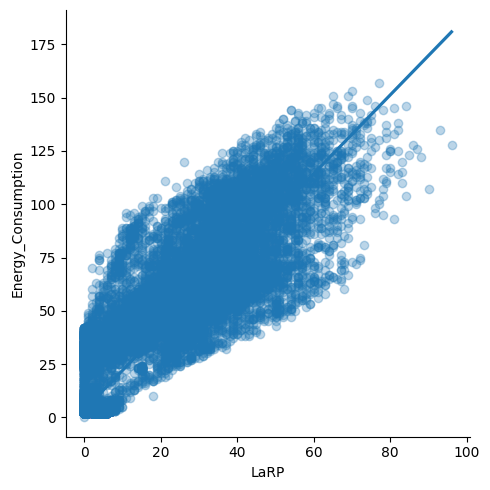

In [375]:
sns.lmplot(x = 'LaRP',
          y = 'Energy_Consumption',
          data = df,
          scatter_kws={'alpha': 0.3})

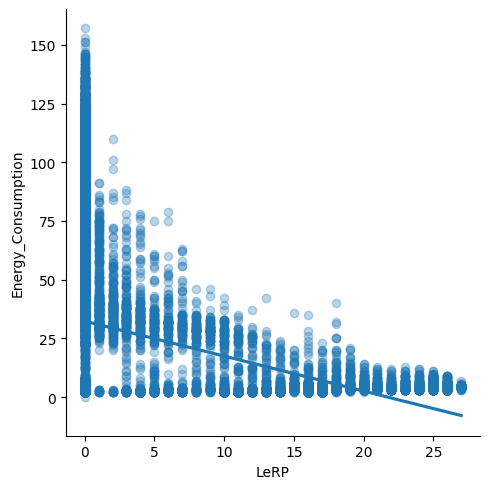

In [377]:
sns.lmplot(x = 'LeRP',
          y = 'Energy_Consumption',
          data = df,
          scatter_kws={'alpha': 0.3})

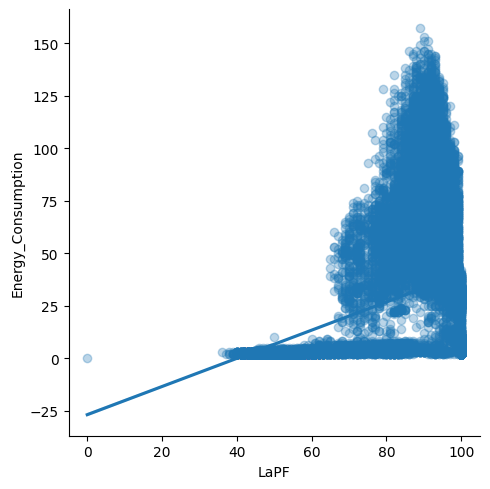

In [378]:
sns.lmplot(x = 'LaPF',
          y = 'Energy_Consumption',
          data = df,
          scatter_kws={'alpha': 0.3})

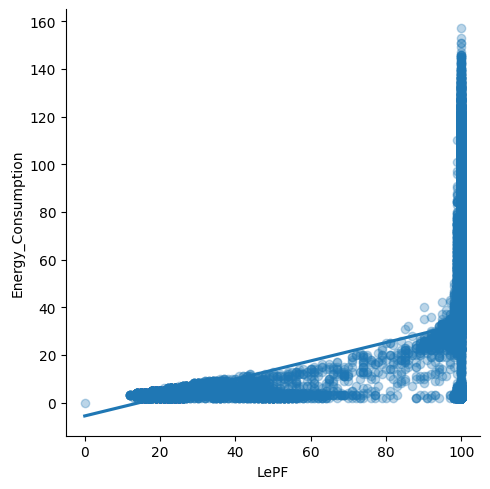

In [379]:
sns.lmplot(x = 'LePF',
          y = 'Energy_Consumption',
          data = df,
          scatter_kws={'alpha': 0.3})

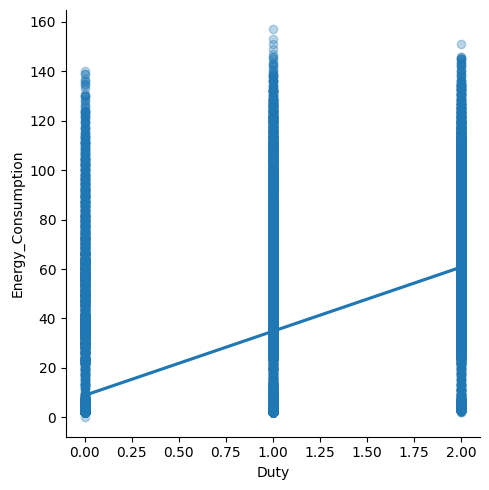

In [380]:
sns.lmplot(x = 'Duty',
          y = 'Energy_Consumption',
          data = df,
          scatter_kws={'alpha': 0.3})

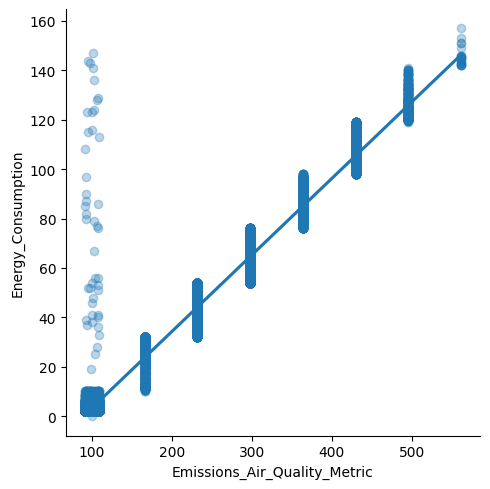

In [381]:
sns.lmplot(x = 'Emissions_Air_Quality_Metric',
          y = 'Energy_Consumption',
          data = df,
          scatter_kws={'alpha': 0.3})

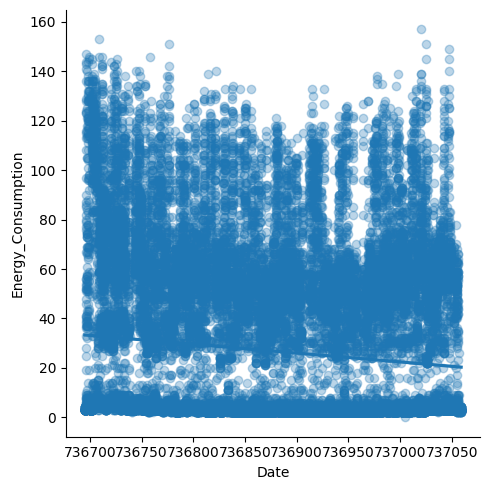

In [382]:
sns.lmplot(x = 'Date',
          y = 'Energy_Consumption',
          data = df,
          scatter_kws={'alpha': 0.3})

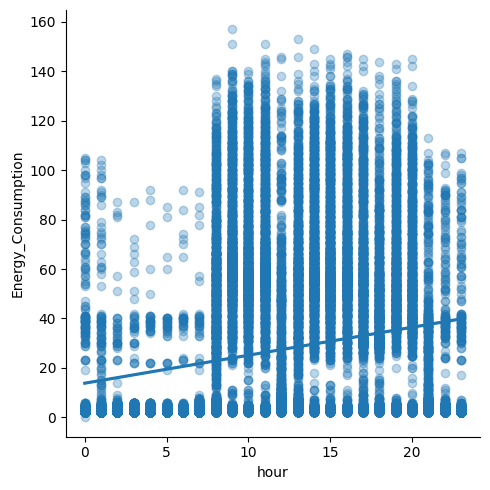

In [383]:
sns.lmplot(x = 'hour',
          y = 'Energy_Consumption',
          data = df,
          scatter_kws={'alpha': 0.3})

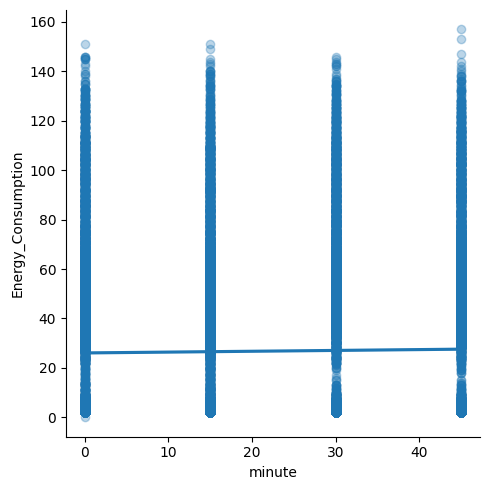

In [384]:
sns.lmplot(x = 'minute',
          y = 'Energy_Consumption',
          data = df,
          scatter_kws={'alpha': 0.3})

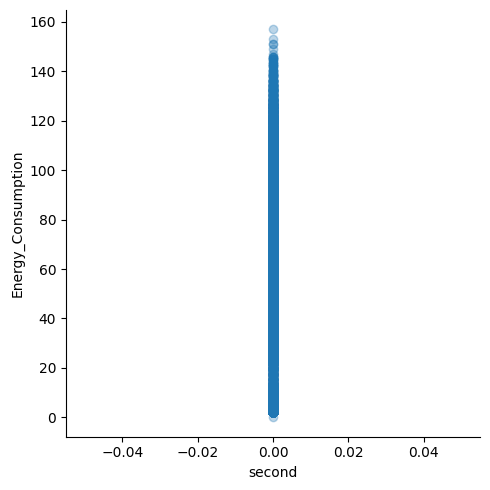

In [385]:
sns.lmplot(x = 'second',
          y = 'Energy_Consumption',
          data = df,
          scatter_kws={'alpha': 0.3})

In [828]:
df.corr().round(2)

Energy_Consumption  LaRP  LeRP  LaPF  LePF  \
Energy_Consumption                          1.00  0.90 -0.32  0.38  0.35   
LaRP                                        0.90  1.00 -0.39  0.15  0.40   
LeRP                                       -0.32 -0.39  1.00  0.53 -0.94   
LaPF                                        0.38  0.15  0.53  1.00 -0.53   
LePF                                        0.35  0.40 -0.94 -0.53  1.00   
Duty                                        0.62  0.45 -0.00  0.52  0.07   
Emissions_Air_Quality_Metric                0.99  0.89 -0.33  0.38  0.36   
Date                                       -0.11 -0.04 -0.03 -0.08 -0.03   

                              Duty  Emissions_Air_Quality_Metric  Date  
Energy_Consumption            0.62                          0.99 -0.11  
LaRP                          0.45                          0.89 -0.04  
LeRP                         -0.00                         -0.33 -0.03  
LaPF                          0.52                          0.38 -0.08  
LePF                          0.07                          0.36 -0.03  
Duty                          1.00                          0.61 -0.01  
Emissions_Air_Quality_Metric  0.61                          1.00 -0.11  
Date                         -0.01                         -0.11  1.00

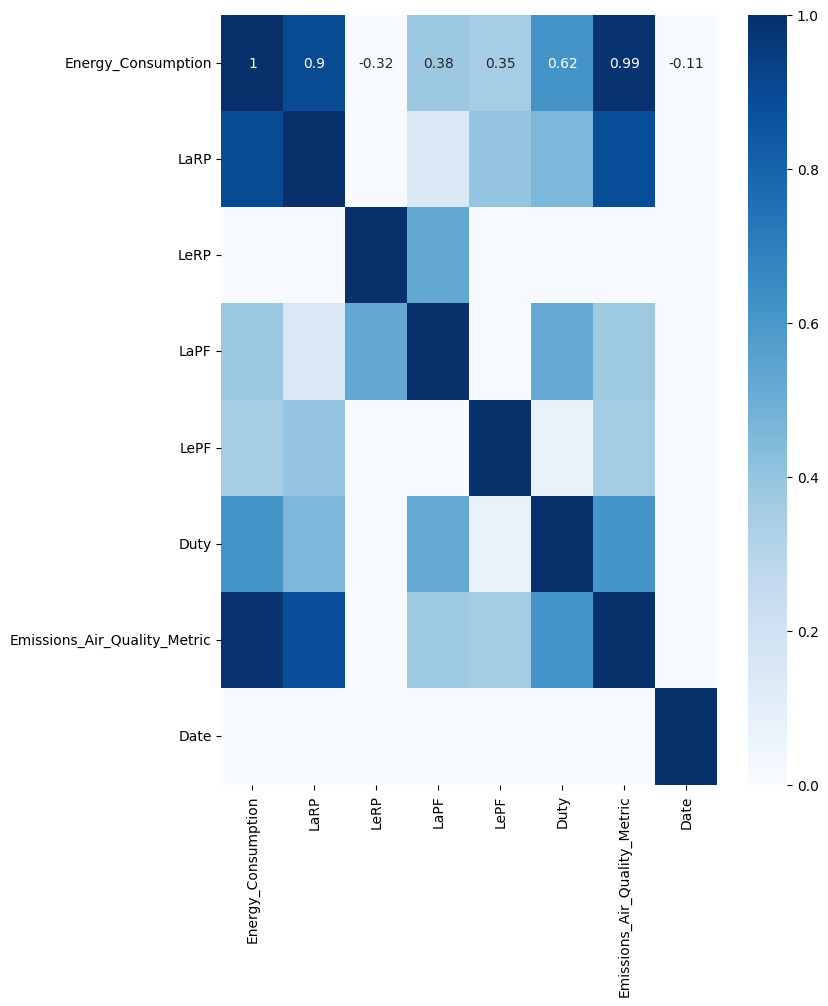

In [852]:
plt.figure(figsize=(8,10))
sns.heatmap(df.corr(),annot=True, vmin = 0,vmax=1,cmap='Blues') 
plt.show()

In [835]:
matrix = df.corr().round(2)
mask = np.triu(np.ones_like(matrix,dtype=bool))
mask

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True,  True,  True],
       [False, False,  True,  True,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True,  True],
       [False, False, False, False,  True,  True,  True,  True],
       [False, False, False, False, False,  True,  True,  True],
       [False, False, False, False, False, False,  True,  True],
       [False, False, False, False, False, False, False,  True]])

<Axes: >

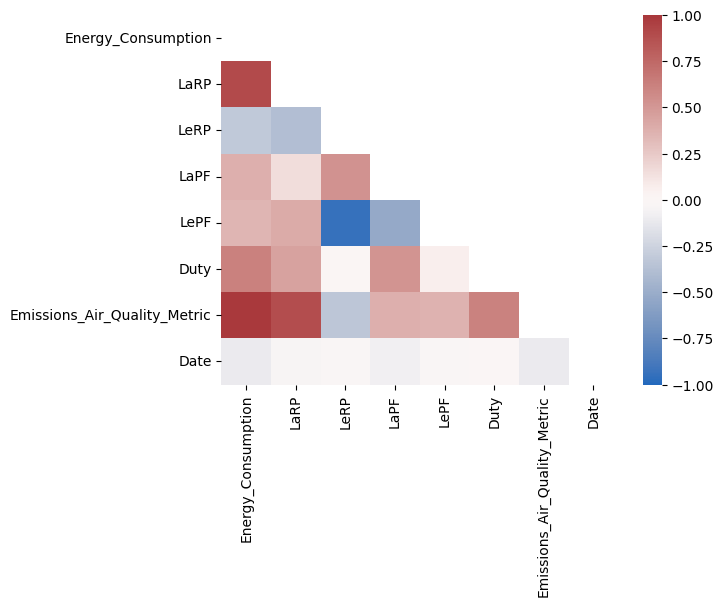

In [836]:
sns.heatmap(matrix,annot=True, vmin = 0,vmax=1,cmap='vlag) 

In [854]:
df.corr().round(2)

Energy_Consumption  LaRP  LeRP  LaPF  LePF  \
Energy_Consumption                          1.00  0.90 -0.32  0.38  0.35   
LaRP                                        0.90  1.00 -0.39  0.15  0.40   
LeRP                                       -0.32 -0.39  1.00  0.53 -0.94   
LaPF                                        0.38  0.15  0.53  1.00 -0.53   
LePF                                        0.35  0.40 -0.94 -0.53  1.00   
Duty                                        0.62  0.45 -0.00  0.52  0.07   
Emissions_Air_Quality_Metric                0.99  0.89 -0.33  0.38  0.36   
Date                                       -0.11 -0.04 -0.03 -0.08 -0.03   

                              Duty  Emissions_Air_Quality_Metric  Date  
Energy_Consumption            0.62                          0.99 -0.11  
LaRP                          0.45                          0.89 -0.04  
LeRP                         -0.00                         -0.33 -0.03  
LaPF                          0.52                          0.38 -0.08  
LePF                          0.07                          0.36 -0.03  
Duty                          1.00                          0.61 -0.01  
Emissions_Air_Quality_Metric  0.61                          1.00 -0.11  
Date                         -0.01                         -0.11  1.00

In [856]:
corr_matrix=df.corr()
corr_matrix["Energy_Consumption"].sort_values(ascending=False)

Energy_Consumption              1.000000
Emissions_Air_Quality_Metric    0.987275
LaRP                            0.895486
Duty                            0.616014
LaPF                            0.382489
LePF                            0.352838
Date                           -0.112870
LeRP                           -0.322834
Name: Energy_Consumption, dtype: float64

In [859]:
corr = df.corr()

# Then follow the steps to calculate and filter relevant features
corr_target = abs(corr["Energy_Consumption"])
relevant_features = corr_target[corr_target > 0.5]

print(relevant_features)

Energy_Consumption              1.000000
LaRP                            0.895486
Duty                            0.616014
Emissions_Air_Quality_Metric    0.987275
Name: Energy_Consumption, dtype: float64


In [860]:
print(df[["LaRP","Duty"]].corr())
print(df[["LaRP","Emissions_Air_Quality_Metric"]].corr())

          LaRP      Duty
LaRP  1.000000  0.454063
Duty  0.454063  1.000000
                                  LaRP  Emissions_Air_Quality_Metric
LaRP                          1.000000                      0.885443
Emissions_Air_Quality_Metric  0.885443                      1.000000


In [ ]:
# we will drop duty
# we are left with 2 features ie LaRP,Emissions_Air_Quality_Metric

In [862]:
df = df.drop(columns=['Duty'])
df.info()

KeyError: "['Duty'] not found in axis"

In [864]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32850 entries, 0 to 32849
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   Energy_Consumption            32850 non-null  int64
 1   LaRP                          32850 non-null  int64
 2   LeRP                          32850 non-null  int64
 3   LaPF                          32850 non-null  int64
 4   LePF                          32850 non-null  int64
 5   Emissions_Air_Quality_Metric  32850 non-null  int64
 6   Date                          32850 non-null  int64
dtypes: int64(7)
memory usage: 1.8 MB


In [866]:
import statsmodels.api as sm
#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X)
#Fitting sm.OLS model
model = sm.OLS(y,X_1).fit()
model.pvalues

const                            1.284000e-56
LaRP                             0.000000e+00
LeRP                             3.278087e-13
LaPF                             0.000000e+00
LePF                            1.814736e-107
Duty                             3.451865e-50
Emissions_Air_Quality_Metric     0.000000e+00
Date                             5.118892e-58
dtype: float64

In [867]:
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['LaRP', 'LeRP', 'LaPF', 'LePF', 'Duty', 'Emissions_Air_Quality_Metric', 'Date']
